# Equivariant Convnext

In [84]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import neptune
from neptune.utils import stringify_unsupported
from ruamel.yaml import YAML
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from torchvision.transforms import RandomRotation, RandomCrop
from tqdm import tqdm
from torchvision import transforms

# ModuleNotFoundError: No module named 'multiplex_model'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from multiplex_model.data import DatasetFromTIFF, PanelBatchSampler, TestCrop
from multiplex_model.losses import nll_loss
from multiplex_model.utils import ClampWithGrad, plot_reconstructs_with_uncertainty, get_scheduler_with_warmup
from multiplex_model.modules import MultiplexAutoencoder
from multiplex_model.run_utils import build_run_name_suffix, SLURM_JOB_ID


from src_from_rudy.utils import setup_seeds, setup_clearml, ChainDataLoader
from src_from_rudy.augmentations import ArcsinhNormalize, MinMaxNormalize, ButterworthFilter, GlobalNormalize, SelectMarkers
from src_from_rudy.config.autoencoder_cells import Config as CellsConfig
from src_from_rudy.config.multiplex_vit_no_bottleneck_autoencoder import Config as TissuesConfig
from src_from_rudy.constants import LOGDIR, IMC_PANEL2_DATA_DIR, PANEL_1_MARKER_NAMES, IMC_PANEL1_DATA_DIR, HALEY_GLIO, DANENBERG_BREAST_DIR, REQUIRED_IMG_SHAPES
from src_from_rudy.datasets.imc_datasets import CellPatchesDataModule, WholeSlidesDataModule, ContrastiveTissuePatchesDataModule, TissuePatchesDataModule



CONFIG_OVERRIDES = {
    "device": "cpu",  # Change to 'cuda:0' if using GPU
    "panel_config": "configs/all_panels_config.yaml",
    "tokenizer_config": "configs/all_markers_tokenizer.yaml"
}

global TOKENIZER, INV_TOKENIZER, PANEL_CONFIG

def apply_overrides(config, overrides):
    for key, value in overrides.items():
        if key in config:
            config[key] = value
        else:
            print(f"Warning: {key} not found in config, skipping override.")
    return config

def load_configuration(config_path):
    yaml = YAML(typ='safe')
    with open(config_path, 'r') as f:
        config = yaml.load(f)
    
    with open("secrets/neptune.yaml", 'r') as f:
        secrets = yaml.load(f)
    config = apply_overrides(config, CONFIG_OVERRIDES)

    prefix = config.get("run_prefix", "").strip()         # empty by default
    suffix = build_run_name_suffix()                               # always unique
    run_name = f"{prefix}_{suffix}" if prefix else suffix

    run = neptune.init_run(
        name=run_name,
        project=secrets['neptune_project'],
        api_token=secrets['neptune_api_token'],
        tags=config['tags'],
    )

    device = config['device']
    print(f'Using device: {device}')

    SIZE = config['input_image_size']
    print(f"INPUT IMAGE SIZE: {SIZE}")
    BATCH_SIZE = config['batch_size']
    NUM_WORKERS = config['num_workers']

    PANEL_CONFIG = YAML().load(open(config['panel_config']))
    TOKENIZER = YAML().load(open(config['tokenizer_config']))
    print(f"Training on datasets: {PANEL_CONFIG['datasets']}")
    MARKERS_SET = {k for dataset in PANEL_CONFIG['datasets'] for k in PANEL_CONFIG['markers'][dataset]}
    print(f"Markers set: {MARKERS_SET}")
    print(f"Number of markers: {len(MARKERS_SET)}")
    TOKENIZER = {k: v for k, v in zip(MARKERS_SET, range(len(MARKERS_SET)))}
    INV_TOKENIZER = {v: k for k, v in TOKENIZER.items()}

    train_transform = Compose([
        # RandomRotation(180),
        TestCrop(SIZE[0]),
    ])

    test_transform = TestCrop(SIZE[0])

    train_dataset = DatasetFromTIFF(
        panels_config=PANEL_CONFIG,
        split='train',
        marker_tokenizer=TOKENIZER,
        transform=train_transform,
        use_median_denoising=False,
        use_butterworth_filter=True
    )

    test_dataset = DatasetFromTIFF(
        panels_config=PANEL_CONFIG,
        split='test',
        marker_tokenizer=TOKENIZER,
        transform=test_transform,
        use_median_denoising=False,
        use_butterworth_filter=True
    )

    train_batch_sampler = PanelBatchSampler(train_dataset, BATCH_SIZE)
    test_batch_sampler = PanelBatchSampler(test_dataset, BATCH_SIZE, shuffle=False)

    train_dataloader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, num_workers=NUM_WORKERS)
    test_dataloader = DataLoader(test_dataset, batch_sampler=test_batch_sampler, num_workers=NUM_WORKERS)

    model_config = {
        'num_channels': len(TOKENIZER),
        'superkernel_config': config['superkernel'],
        'encoder_config': config['encoder'],
        'decoder_config': config['decoder'],
    }

    if config["model_type"] == "EquivariantConvnext":
        from multiplex_model.equivariant_modules import EquivariantMultiplexAutoencoder
        model = EquivariantMultiplexAutoencoder(**model_config).to(device)
    elif config["model_type"] == "Convnext":
        model = MultiplexAutoencoder(**model_config).to(device)

    print(f'Model created with config: {model_config}')
    print(f'Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters')
    print(f'Model: {model}')
    print(f'Training on {len(train_dataloader.dataset)} training samples and {len(test_dataloader.dataset)} test samples')
    print(f'Batch size: {BATCH_SIZE}, Number of workers: {NUM_WORKERS}')
    return model, train_dataloader, test_dataloader, TOKENIZER, INV_TOKENIZER, config

config_path = "/raid/szlukasik/immu-vis/multiplex-image-model/train_masked_equivariant_config.yaml"
model, train_dataloader, test_dataloader, TOKENIZER, INV_TOKENIZER, config = load_configuration(config_path)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/immu-vis/patch-autoencoders/e/IM-190
Using device: cpu
INPUT IMAGE SIZE: [113, 113]
Training on datasets: ['nsclc2-panel1']
Markers set: {'PD1', 'CD20', 'CD68', 'CD27', 'CD303', 'Ki67', 'CD16', 'CD7', 'DNA2', 'Ecad', 'PDGFRb', 'Histone H3', 'CD4', 'CD11c', 'ICOS', 'CD15', 'B2M', 'CD14', 'CD163', 'CD8a', 'CD206', 'Carbonic Anhydrase', 'CD45RO', 'cl.PARP', 'CD40', 'GrzB', 'CD38', 'LAG3', 'PDL1', 'VISTA', 'TCF7', 'MPO', 'HLADR', 'CD33', 'FOXP3', 'Ido1', 'DNA1', 'CD45RA', 'SMA', 'CD3'}
Number of markers: 40
Model created with config: {'num_channels': 40, 'superkernel_config': {'embedding_dim': 96, 'num_layers': 0, 'num_heads': None, 'layer_type': 'linear', 'kernel_size': None, 'mlp_ratio': None}, 'encoder_config': {'layers_blocks': [1, 1, 1], 'embedding_dims': [192, 384, 512], 'maximum_frequency': 1}, 'decoder_config': {'decoded_embed_dim': 512, 'num_blocks': 2}}
Model has 42541312 trainable parameters
Model: 

In [ ]:
from multiplex_model.equivariant_modules import EquivariantMultiplexAutoencoder

model_config = {
        'num_channels': len(TOKENIZER),
        'superkernel_config': config['superkernel'],
        'encoder_config': config['encoder'],
        'decoder_config': config['decoder'],
    }

device = "cpu"

if config["model_type"] == "EquivariantConvnext":
    model = EquivariantMultiplexAutoencoder(**model_config).to(device)

In [ ]:
model_dev

In [191]:
model

<All keys matched successfully>

In [291]:
batch = next(iter(test_dataloader))
img = batch["image"]
img = img[:, :, 1:-2, 1:-2]  # Crop to 60x60 if original is 64x64
img.shape

torch.Size([1, 40, 97, 97])

In [131]:
img, channel_ids, panel_idx, img_paths = next(iter(test_dataloader))

In [ ]:
batch.keys()

In [ ]:
img.shape

In [6]:
# load model ckpt
# ckpt_path = "checkpoints/checkpoint-IM-41-epoch_149.pth"
ckpt_path = "/raid/szlukasik/immu-vis/multiplex-image-model/checkpoints/checkpoint-EquivariantConvnext_20250827_002044_J1611-epoch_999.pth"

state_dict = torch.load(ckpt_path, map_location='cpu')

/tmp/ipykernel_178767/3874083919.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cpu')


In [7]:
model.load_state_dict(state_dict["model_state_dict"])

<All keys matched successfully>

In [8]:
model = model.to('cuda:0')

In [ ]:
print("lol")

In [ ]:
# def get_results_for_dataloader(model, dataloader, device='cuda:0'):
#     model.eval()
#     all_imgs = []
#     all_reconstructions = []
#     all_uncertainties = []
#     with torch.no_grad():
#         for img, channel_ids, panel_idx, img_path in tqdm(dataloader):
#             img = img.to(device)
#             channel_ids = channel_ids.to(device)
#             panel_idx = panel_idx.to(device)

#             reconstruction, uncertainty = model(img, channel_ids, panel_idx)
#             all_imgs.append(img.cpu())
#             all_reconstructions.append(reconstruction.cpu())
#             all_uncertainties.append(uncertainty.cpu())
#     all_imgs = torch.cat(all_imgs, dim=0)
#     all_reconstructions = torch.cat(all_reconstructions, dim=0)
#     all_uncertainties = torch.cat(all_uncertainties, dim=0)
#     return all_imgs, all_reconstructions, all_uncertainties

In [114]:
device

device(type='cuda', index=1)

In [138]:
min_channels_frac = 0.5
device = model.parameters().__next__().device  # Get the device from model parameters
rand_gen = torch.Generator().manual_seed(42)

img = img.to(device).to(torch.float32)
batch_size, num_channels, H, W = img.shape
min_channels = int(np.ceil(num_channels * min_channels_frac))
if min_channels < num_channels:
    num_sampled_channels = torch.randint(min_channels, num_channels, (1,), generator=rand_gen).item()
else:
    num_sampled_channels = num_channels

print(num_sampled_channels)

channels_subset_idx = [
    np.random.choice(
        np.arange(num_channels), 
        size=(1, num_sampled_channels), 
        replace=False,
    ) for _ in range(batch_size)
]

channels_subset_indices = np.concatenate(channels_subset_idx, axis=0)
channels_subset_indices = torch.tensor(channels_subset_indices, dtype=torch.long).to(device)  # Shape: [batch_size, num_sampled_channels]

channels_subset_indices = channels_subset_indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, H, W)  # Shape: [batch_size, num_sampled_channels, H, W]
masked_img = torch.gather(img, dim=1, index=channels_subset_indices).to(device)  # Gather the selected channels

# Gather corresponding channel IDs
channel_ids = torch.arange(num_channels).unsqueeze(0).expand(batch_size, -1).to(device)  # Shape: [batch_size, num_channels]
active_channel_ids = torch.gather(channel_ids, dim=1, index=channels_subset_indices[:, :, 0, 0]).to(device)

channel_ids = channel_ids.to(device)
masked_img = masked_img.to(torch.float32)
img = img.to(device)

with torch.no_grad():
#    output = model(masked_img, active_channel_ids, channel_ids, True)
    output = model(img, channel_ids, channel_ids, True)
    features = output["features"]
    reconstructions = output["output"]
mi, logsigma = reconstructions.unbind(dim=-1)
mi = torch.sigmoid(mi)

22


In [149]:
channels_subset_indices.shape

torch.Size([4, 22, 113, 113])

In [139]:
channel_ids

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')

In [142]:
active_channel_ids

tensor([[18,  8,  7, 29, 35, 19, 16, 13,  9, 39,  1,  6, 25, 23, 30, 34,  4, 17,
         15,  2, 12, 11],
        [19, 31, 30, 16, 13,  2,  1, 15, 14, 18, 26, 11, 17,  4, 38, 24, 35,  3,
         10, 34, 23, 20],
        [27, 29, 24, 20,  8,  2,  7, 22,  5,  3, 18, 11, 15, 25, 36, 14, 33,  1,
          9,  6,  0, 34],
        [26, 29, 28, 19,  7, 32, 15, 24,  0, 11, 38, 37, 30, 17, 34,  4,  8,  5,
         31, 36,  1, 18]], device='cuda:0')

In [134]:
channels_subset_indices

tensor([[[[37, 37, 37,  ..., 37, 37, 37],
          [37, 37, 37,  ..., 37, 37, 37],
          [37, 37, 37,  ..., 37, 37, 37],
          ...,
          [37, 37, 37,  ..., 37, 37, 37],
          [37, 37, 37,  ..., 37, 37, 37],
          [37, 37, 37,  ..., 37, 37, 37]],

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 2,  2,  2,  ...,  2,  2,  2],
          [ 2,  2,  2,  ...,  2,  2,  2],
          [ 2,  2,  2,  ...,  2,  2,  2],
          ...,
          [ 2,  2,  2,  ...,  2,  2,  2],
          [ 2,  2,  2,  ...,  2,  2,  2],
          [ 2,  2,  2,  ...,  2,  2,  2]],

         ...,

         [[29, 29, 29,  ..., 29, 29, 29],
          [29, 29, 29,  ..., 29, 29, 29],
          [29, 29, 29,  ..., 29, 29, 29],
          ...,
          [29, 29, 29,  ..., 29, 29, 

In [286]:
active_channel_ids, channel_ids

(tensor([[10, 27,  3, 25,  9,  5, 29, 24, 14,  1,  4, 16, 37, 11, 28, 21, 33, 26,
          31,  7, 13, 20]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
          36, 37, 38, 39]]))

In [ ]:
device='cuda:1'

In [ ]:
results_dir = "./resu;ts/test/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)



In [ ]:
model.eval()

In [ ]:
device = "cuda:1"

In [38]:
import math, torch, torchvision.transforms.functional as TF
import torch.nn.functional as F

def circular_mask(H, W, device):
    """Largest inscribed circle for an H×W map."""
    Y, X = torch.meshgrid(torch.arange(H, device=device),
                          torch.arange(W, device=device),
                          indexing='ij')
    r2 = (X - W//2)**2 + (Y - H//2)**2
    return (r2 <= (min(H, W)//2)**2).float()


def rotate_tensor(x, theta_deg, mode='bilinear'):
    if abs(theta_deg) % 90 == 0:           # hit multiple of 90°
        k = int(round(theta_deg / 90)) % 4
        return torch.rot90(x, k=k, dims=(-2, -1))
    # torchvision.rotate handles the centre correctly
    return TF.rotate(
        x, theta_deg,
        interpolation=TF.InterpolationMode.BILINEAR if mode=='bilinear' else TF.InterpolationMode.NEAREST,
        expand=False,                       # keep canvas size
        center=((x.shape[-1]-1)/2, (x.shape[-2]-1)/2)   # exact pixel centre
    )


def eval(org_image, channel_ids, panel_idx, img_path):
    results = {}
    org_image = org_image.to(torch.float32)
    batch_size = org_image.shape[0]
    # print(org_image.shape)
    for (rotation, flip) in [(0, "mask"), (0, 1), (90, 1), (180, 1), (270, 1), (30, 0), (45, 0), (135, 0)]:
        use_mask = False
        if flip == "mask":
            flip = 0
            use_mask = True
        for flip in range(flip+1):
            if rotation > 0 and rotation % 90 == 0:
                img = torch.rot90(org_image, k=rotation // 90, dims=[-2, -1])
            elif rotation > 0:
                mask = circular_mask(org_image.shape[2], org_image.shape[3], device=org_image.device)
                img = org_image * mask.unsqueeze(0).unsqueeze(0)
                img = rotate_tensor(img, rotation, mode='bilinear')
            else:
                img = org_image
                if use_mask:
                    mask = circular_mask(org_image.shape[2], org_image.shape[3], device=org_image.device)
                    img = org_image * mask.unsqueeze(0).unsqueeze(0)
            if flip:
                img = torch.flip(img, dims=[3])
            else:
                img = img
            key = f"r{rotation}" + ("_f" if flip else "_nf") + ("_mask" if use_mask else "")
            img = img.to(device)
            num_channels = img.shape[1]
            channel_ids = torch.arange(num_channels).unsqueeze(0).expand(org_image.shape[0], -1).to(device)  # Shape: [batch_size, num_channels]
            # print(img.shape, channel_ids.shape)
            # print(img.mean(), img.std())
            # print(channel_ids)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                print(channel_ids)
                output = model(img, channel_ids, channel_ids, True)
                features = output["features"]
                reconstructions = output["output"]
                reconstructions = reconstructions[:, :, 3:-4, 3:-4]
                mi, logsigma = reconstructions.unbind(dim=-1)
                mi = torch.sigmoid(mi)
                # print(mi.shape, img.shape)
                mae = torch.abs(mi - img).mean().item()
                results[key] = {}
                results[key]["latent"] = features[-1].cpu().detach().float().numpy()
                # results["img_path"] = img_path
                # print(results[key]["latent"].shape)
                results[key]["img"] = img.cpu().detach().numpy()
                results[key]["reconstruction"] = mi.cpu().detach().float().numpy()
                results[key]["logsigma"] = logsigma.cpu().detach().float().numpy()
    return results
all_results = []
# device = model.parameters().__next__().device  # Get the device from model parameters
# with torch.no_grad():
#     for i, (org_image, channel_ids, panel_idx, img_path) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
#         results = eval(org_image=org_image, channel_ids=channel_ids, panel_idx=panel_idx, img_path=img_path)
#         all_results.append(results)
#         if i * batch_size >= 12:
#             break


all_results = []
# path = "/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10022152-LUNG-VAR-TIS-01-IMC-01_002.tiff"
path = "/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10018884-LUNG-VAR-TIS-01-IMC-01_002.tiff"
dataset = "nsclc2-panel1"
key = (path, dataset)
idx = test_dataloader.dataset.imgs.index(key)

org_image, channel_ids, panel_idx, img_path = test_dataloader.dataset[idx]
print(img_path, org_image.shape, channel_ids, panel_idx)
org_image = torch.tensor(org_image).unsqueeze(0)
channel_ids = torch.tensor(channel_ids).unsqueeze(0)
# panel_idx = torch.tensor([panel_idx])
img_path = [img_path]
results = eval(org_image=org_image, channel_ids=channel_ids, panel_idx=panel_idx, img_path=img_path)
all_results.append(results)



/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10018884-LUNG-VAR-TIS-01-IMC-01_002.tiff (40, 113, 113) tensor([16, 21, 13, 17, 15,  6, 18,  1, 20,  3, 39,  4, 33, 26, 12, 24, 37, 22,
         2,  7, 19, 23, 36,  8,  9, 34, 25, 11, 32, 14, 35,  5, 27, 31,  0, 10,
        28, 38, 30, 29]) nsclc2-panel1
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')


/tmp/ipykernel_178767/1238263990.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel_ids = torch.tensor(channel_ids).unsqueeze(0)


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 3

In [10]:
device = model.parameters().__next__().device  # Get the device from model parameters

In [75]:
import math, torch, torchvision.transforms.functional as TF
import torch.nn.functional as F

def circular_mask(H, W, device):
    """Largest inscribed circle for an H×W map."""
    Y, X = torch.meshgrid(torch.arange(H, device=device),
                          torch.arange(W, device=device),
                          indexing='ij')
    r2 = (X - W//2)**2 + (Y - H//2)**2
    return (r2 <= (min(H, W)//2)**2).float()


def rotate_tensor(x, theta_deg, mode='bilinear'):
    if abs(theta_deg) % 90 == 0:           # hit multiple of 90°
        k = int(round(theta_deg / 90)) % 4
        return torch.rot90(x, k=k, dims=(-2, -1))
    # torchvision.rotate handles the centre correctly
    return TF.rotate(
        x, theta_deg,
        interpolation=TF.InterpolationMode.BILINEAR if mode=='bilinear' else TF.InterpolationMode.NEAREST,
        expand=False,                       # keep canvas size
        center=((x.shape[-1]-1)/2, (x.shape[-2]-1)/2)   # exact pixel centre
    )


def eval(org_image, channel_ids, panel_idx, img_path):
    results = {}
    org_image = org_image.to(torch.float32)
    batch_size = org_image.shape[0]
    # print(org_image.shape)

    latent_org = None
    latent_mask = None

    for (rotation, flip) in [(0, "mask"), (0, 0), (90, 1), (180, 1), (270, 1), (30, 0), (45, 0), (135, 0)]:
        use_mask = False
        if flip == "mask":
            flip = 0
            use_mask = True
        for flip in range(flip+1):
            if rotation > 0 and rotation % 90 == 0:
                img = torch.rot90(org_image, k=rotation // 90, dims=[-2, -1])
            elif rotation > 0:
                mask = circular_mask(org_image.shape[2], org_image.shape[3], device=org_image.device)
                img = org_image * mask.unsqueeze(0).unsqueeze(0)
                img = rotate_tensor(img, rotation, mode='bilinear')
            else:
                img = org_image
                if use_mask:
                    mask = circular_mask(org_image.shape[2], org_image.shape[3], device=org_image.device)
                    img = org_image * mask.unsqueeze(0).unsqueeze(0)
            if flip:
                img = torch.flip(img, dims=[3])
            else:
                img = img
            key = f"r{rotation}" + ("_f" if flip else "_nf") + ("_mask" if use_mask else "")
            img = img.to(device)
            num_channels = img.shape[1]
            channel_ids = torch.arange(num_channels).unsqueeze(0).expand(org_image.shape[0], -1).to(device)  # Shape: [batch_size, num_channels]
            # print(img.shape, channel_ids.shape)
            # print(img.mean(), img.std())
            # print(channel_ids)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                # print(channel_ids)
                output = model(img, channel_ids, channel_ids, True)
                features = output["features"]
                reconstructions = output["output"]
                reconstructions = reconstructions[:, :, 3:-4, 3:-4]
                mi, logsigma = reconstructions.unbind(dim=-1)
                mi = torch.sigmoid(mi)
                # print(mi.shape, img.shape)
                # mae = torch.abs(mi - img).mean().item()
                results[key] = {}
                # results["img_path"] = img_path
                # print(results[key]["latent"].shape)
                # results[key]["latent"] = features[-1].cpu().detach().float().numpy()
                # results[key]["img"] = img.cpu().detach().numpy()
                # results[key]["reconstruction"] = mi.cpu().detach().float().numpy()
                # results[key]["logsigma"] = logsigma.cpu().detach().float().numpy()
                
                latent = features[-1].cpu().detach().float()
                if (rotation, flip, use_mask) == (0, 0, True):
                    latent_mask = latent
                    # results[key]["latent"] = latent_mask.numpy()
                    continue
                if (rotation, flip, use_mask) == (0, 0, False):
                    latent_org = latent
                    # results[key]["latent"] = latent_org.numpy()
                    continue
            
                # print(f"Adding key: {key}, rotation: {rotation}, flip: {flip}, use_mask: {use_mask}")
                if flip:
                    latent = torch.flip(latent, dims=[3])
                if rotation > 0 and rotation % 90 == 0:
                    # print(f"Rotating by {-rotation} degrees using rot90")
                    latent = torch.rot90(latent, k=(-rotation // 90), dims=[-2, -1])
                elif rotation > 0:
                    # print(f"Rotating by {-rotation} degrees using rotate_tensor")
                    latent = rotate_tensor(latent, -rotation, mode='bilinear')
                
                print(latent.shape, latent_org.shape, latent_mask.shape)
                if rotation % 90 == 0:
                    equivariance_error = ((latent - latent_org) ** 2).mean([1, 2, 3])
                    print(equivariance_error.shape)
                else:
                    equivariance_error = ((latent - latent_mask) ** 2).mean([1, 2, 3])
            
                results[key]["equiv_mse"] = equivariance_error
                # results[key]["latent"] = latent.numpy()
    return results
all_results = []
device = model.parameters().__next__().device  # Get the device from model parameters
with torch.no_grad():
    for i, (org_image, channel_ids, panel_idx, img_path) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        results = eval(org_image=org_image, channel_ids=channel_ids, panel_idx=panel_idx, img_path=img_path)
        all_results.append(results)
        # if i >= 0:
        #     break


# all_results = []
# # path = "/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10022152-LUNG-VAR-TIS-01-IMC-01_002.tiff"
# path = "/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10018884-LUNG-VAR-TIS-01-IMC-01_002.tiff"
# dataset = "nsclc2-panel1"
# key = (path, dataset)
# idx = test_dataloader.dataset.imgs.index(key)

# org_image, channel_ids, panel_idx, img_path = test_dataloader.dataset[idx]
# print(img_path, org_image.shape, channel_ids, panel_idx)
# org_image = torch.tensor(org_image).unsqueeze(0)
# channel_ids = torch.tensor(channel_ids).unsqueeze(0)
# # panel_idx = torch.tensor([panel_idx])
# img_path = [img_path]
# results = eval(org_image=org_image, channel_ids=channel_ids, panel_idx=panel_idx, img_path=img_path)
# all_results.append(results)


  0%|                                                                                                                                                                                      | 0/37 [00:00<?, ?it/s]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


  3%|████▋                                                                                                                                                                         | 1/37 [00:05<03:12,  5.35s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


  5%|█████████▍                                                                                                                                                                    | 2/37 [00:09<02:41,  4.60s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


  8%|██████████████                                                                                                                                                                | 3/37 [00:13<02:28,  4.37s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 11%|██████████████████▊                                                                                                                                                           | 4/37 [00:17<02:21,  4.27s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 14%|███████████████████████▌                                                                                                                                                      | 5/37 [00:21<02:14,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 16%|████████████████████████████▏                                                                                                                                                 | 6/37 [00:25<02:10,  4.20s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 19%|████████████████████████████████▉                                                                                                                                             | 7/37 [00:30<02:05,  4.20s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 22%|█████████████████████████████████████▌                                                                                                                                        | 8/37 [00:34<02:02,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 24%|██████████████████████████████████████████▎                                                                                                                                   | 9/37 [00:38<01:57,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 27%|██████████████████████████████████████████████▊                                                                                                                              | 10/37 [00:42<01:53,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 30%|███████████████████████████████████████████████████▍                                                                                                                         | 11/37 [00:47<01:49,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 32%|████████████████████████████████████████████████████████                                                                                                                     | 12/37 [00:51<01:45,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 35%|████████████████████████████████████████████████████████████▊                                                                                                                | 13/37 [00:55<01:41,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                           | 14/37 [00:59<01:36,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                      | 15/37 [01:03<01:32,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                  | 16/37 [01:08<01:28,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                             | 17/37 [01:12<01:24,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 18/37 [01:16<01:20,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 19/37 [01:20<01:15,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 20/37 [01:24<01:11,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 21/37 [01:29<01:07,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 22/37 [01:33<01:03,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 23/37 [01:37<00:58,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 24/37 [01:41<00:54,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 25/37 [01:45<00:50,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 26/37 [01:50<00:46,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 27/37 [01:54<00:42,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 28/37 [01:58<00:37,  4.20s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 29/37 [02:02<00:33,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 30/37 [02:07<00:29,  4.20s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 31/37 [02:11<00:25,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 32/37 [02:15<00:21,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 33/37 [02:19<00:16,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 34/37 [02:23<00:12,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 35/37 [02:28<00:08,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 36/37 [02:32<00:04,  4.21s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])
torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [02:36<00:00,  4.22s/it]

torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15]) torch.Size([4, 512, 15, 15])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [02:37<00:00,  4.24s/it]


In [46]:
len(all_results)

2

In [76]:
# compute average error for each rotation
avg_errors = {}
for i, results in enumerate(all_results):
    for key, value in results.items():
        if "equiv_mse" in value:
            if key not in avg_errors:
                avg_errors[key] = []
            avg_errors[key].append(value["equiv_mse"])
avg_errors = {k: torch.mean(torch.stack(v).flatten(), dim=0) for k, v in avg_errors.items()}

In [77]:
avg_errors

{'r90_nf': tensor(1.4678e-06),
 'r90_f': tensor(0.0045),
 'r180_nf': tensor(1.5531e-06),
 'r180_f': tensor(0.0045),
 'r270_nf': tensor(1.4811e-06),
 'r270_f': tensor(0.0045),
 'r30_nf': tensor(0.0061),
 'r45_nf': tensor(0.0067),
 'r135_nf': tensor(0.0096)}

In [209]:
all_results[0]["r0_nf_mask"]["latent"].shape

(1, 512, 15, 15)

In [67]:
all_results_concat = [
    {
        k: {
            h: all_results[i][k][h][j] for h in all_results[i]["r0_nf"].keys()
        } for k in all_results[i].keys()
    } for i in range(len(all_results)) for j in range(all_results[i]["r0_nf"]["latent"].shape[0])
]
all_results = all_results_concat

(1, 512, 15, 15) (1, 512, 15, 15)
torch.Size([1, 512, 15, 15])
Latent shape: (1, 512, 15, 15), Rotated latent shape: torch.Size([1, 512, 15, 15])
No rotation applied
Equivariance Error (MSE) for channel 5: 0.006509027909487486


/tmp/ipykernel_1693614/2765757990.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_latent = torch.tensor(rotated_output)


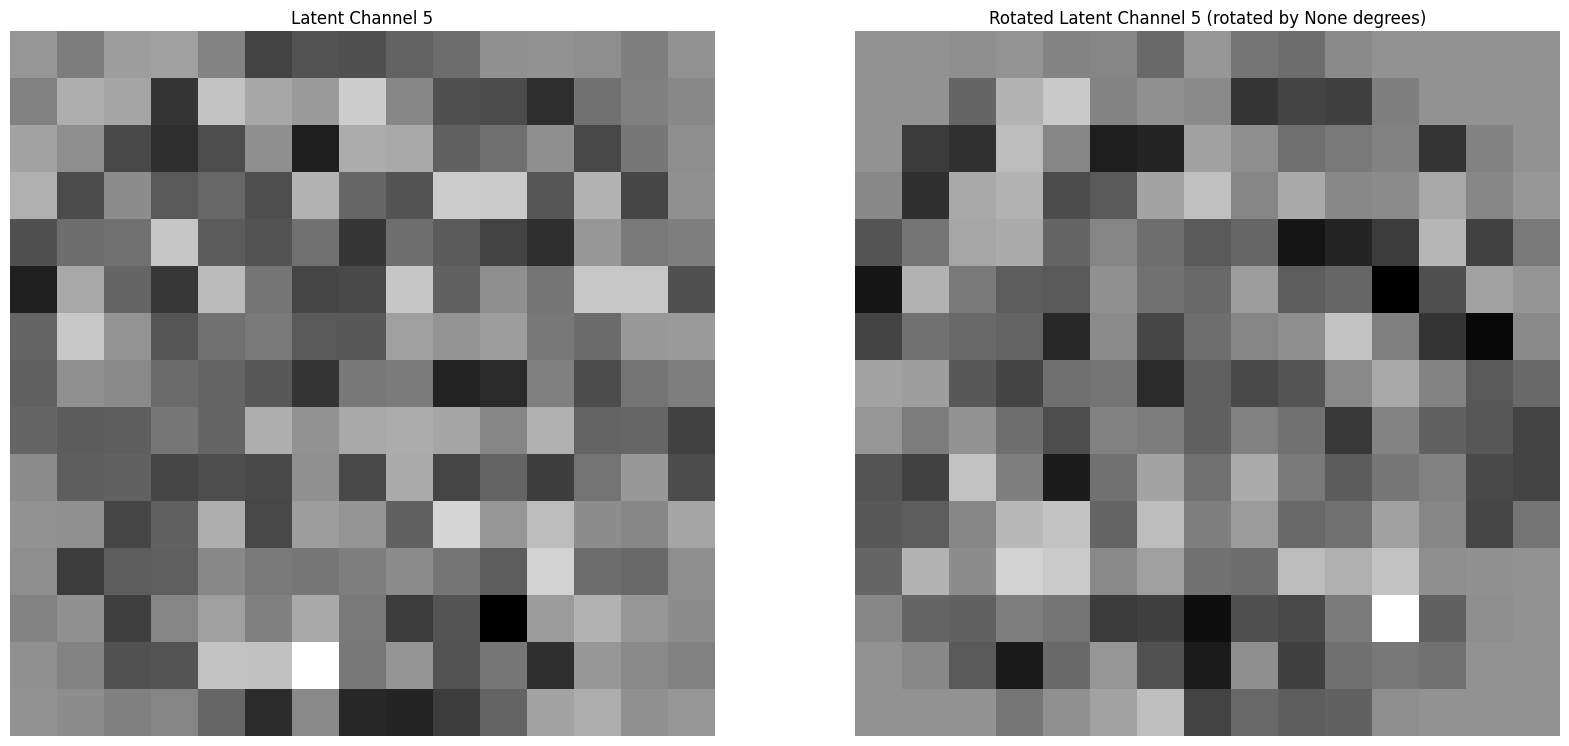

In [228]:
def plot_latents_continous(all_results, idx, rotation=90,channel_idx=0, layer="latent"):
    if rotation % 90 != 0:
        latent = all_results[idx]["r0_nf_mask"][layer]
    else:
        latent = all_results[idx]["r0_nf"][layer]
    latent_rot = all_results[idx][f"r{rotation}_nf"][layer]
    print(latent.shape, latent_rot.shape)
    
    if rotation % 90 == 0:
        latent_rot_back = torch.rot90(torch.tensor(latent_rot), k=-rotation // 90, dims=(-2, -1))
    else:
        latent_rot_back = rotate_tensor(torch.tensor(latent_rot), -rotation, mode='bilinear')
    print(latent_rot_back.shape)
    channel_idx = channel_idx
    plot_latents(latent, latent_rot_back, rotation=None, layer_idx=-1, chanel_idx=channel_idx)

plot_latents_continous(all_results, idx=0, rotation=30, channel_idx=5)


(512, 15, 15) (512, 15, 15)
Latent shape: (1, 512, 15, 15), Rotated latent shape: torch.Size([1, 512, 15, 15])
No rotation applied
Equivariance Error (MSE) for channel 5: 0.006057653576135635


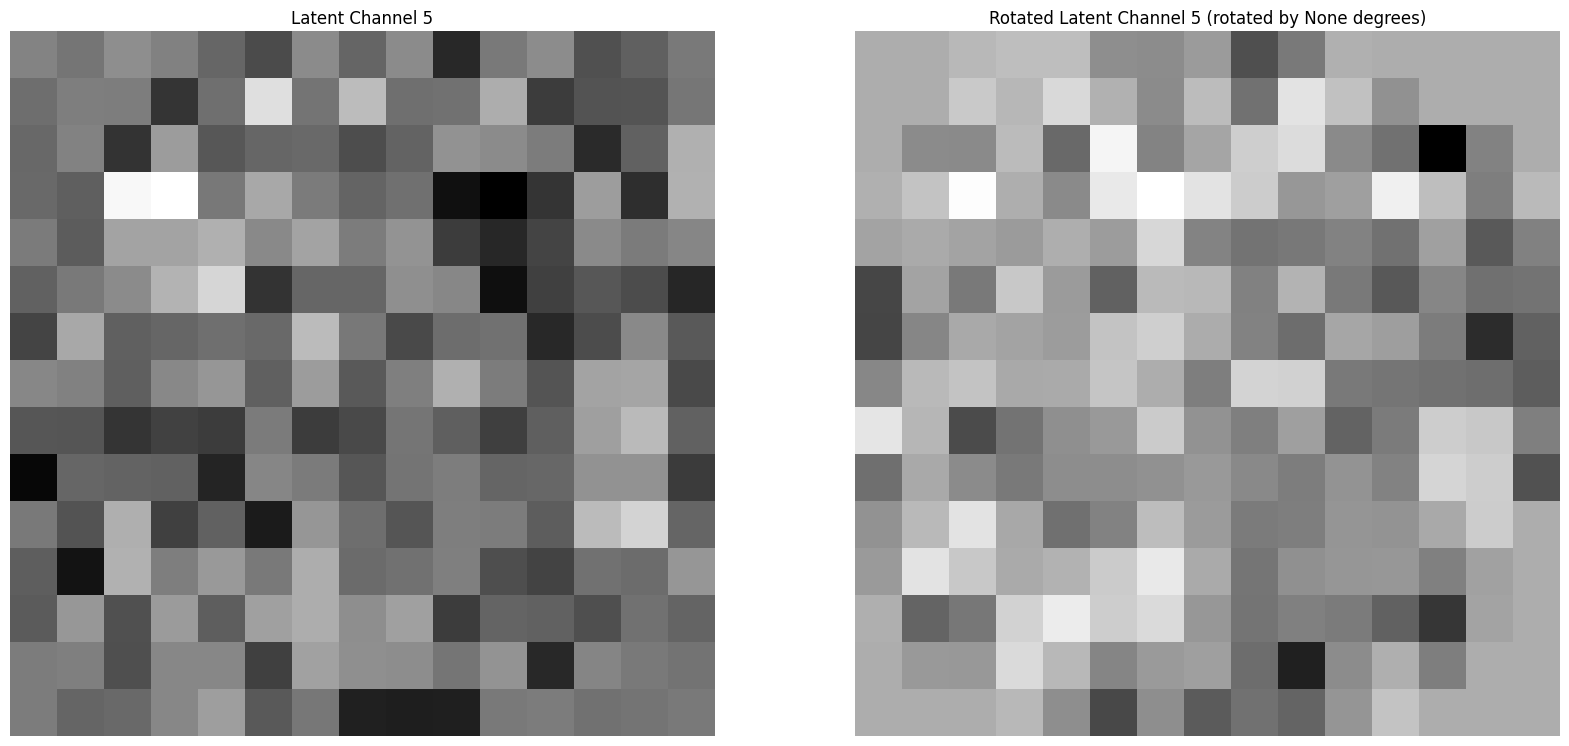

In [63]:
def plot_latents_continous(all_results, idx, rotation=90,channel_idx=0, layer="latent"):
    if rotation % 90 != 0:
        latent = all_results[idx]["r0_nf_mask"][layer]
    else:
        latent = all_results[idx]["r0_nf"][layer]
    latent_rot = all_results[idx][f"r{rotation}_nf"][layer]
    print(latent.shape, latent_rot.shape)
    
    # if rotationw % 90 == 0:
    #     latent_rot_back = torch.rot90(torch.tensor(latent_rot), k=-rotation // 90, dims=(-2, -1))
    # else:
    #     latent_rot_back = rotate_tensor(torch.tensor(latent_rot), -rotation, mode='bilinear')
    # print(latent_rot_back.shape)
    channel_idx = channel_idx
    plot_latents(latent[np.newaxis], latent_rot[np.newaxis], rotation=None, layer_idx=-1, chanel_idx=channel_idx)

plot_latents_continous(all_results, idx=0, rotation=30, channel_idx=5)


(512, 15, 15) (512, 15, 15)
torch.Size([512, 15, 15])
Latent shape: (1, 512, 15, 15), Rotated latent shape: torch.Size([1, 512, 15, 15])
No rotation applied
Equivariance Error (MSE) for channel 5: 0.008153427392244339


/tmp/ipykernel_178767/2765757990.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_latent = torch.tensor(rotated_output)


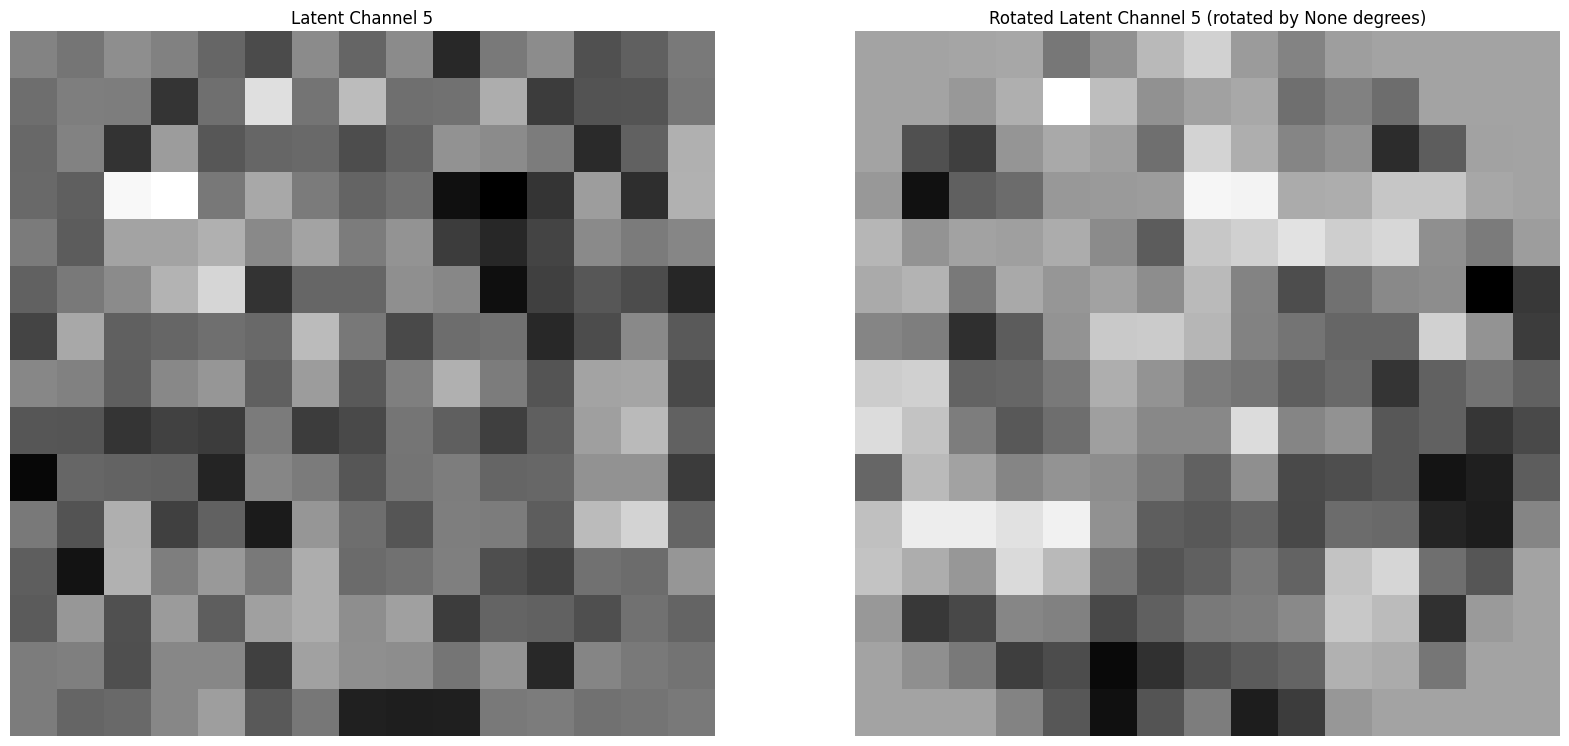

In [49]:
plot_latents_continous(all_results, idx=0, rotation=30, channel_idx=5)


(1, 40, 113, 113) (1, 40, 113, 113)
torch.Size([1, 40, 113, 113])
Latent shape: (1, 40, 113, 113), Rotated latent shape: torch.Size([1, 40, 113, 113])
No rotation applied
Equivariance Error (MSE) for channel 5: 0.0025113627780228853


/tmp/ipykernel_1693614/2765757990.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_latent = torch.tensor(rotated_output)


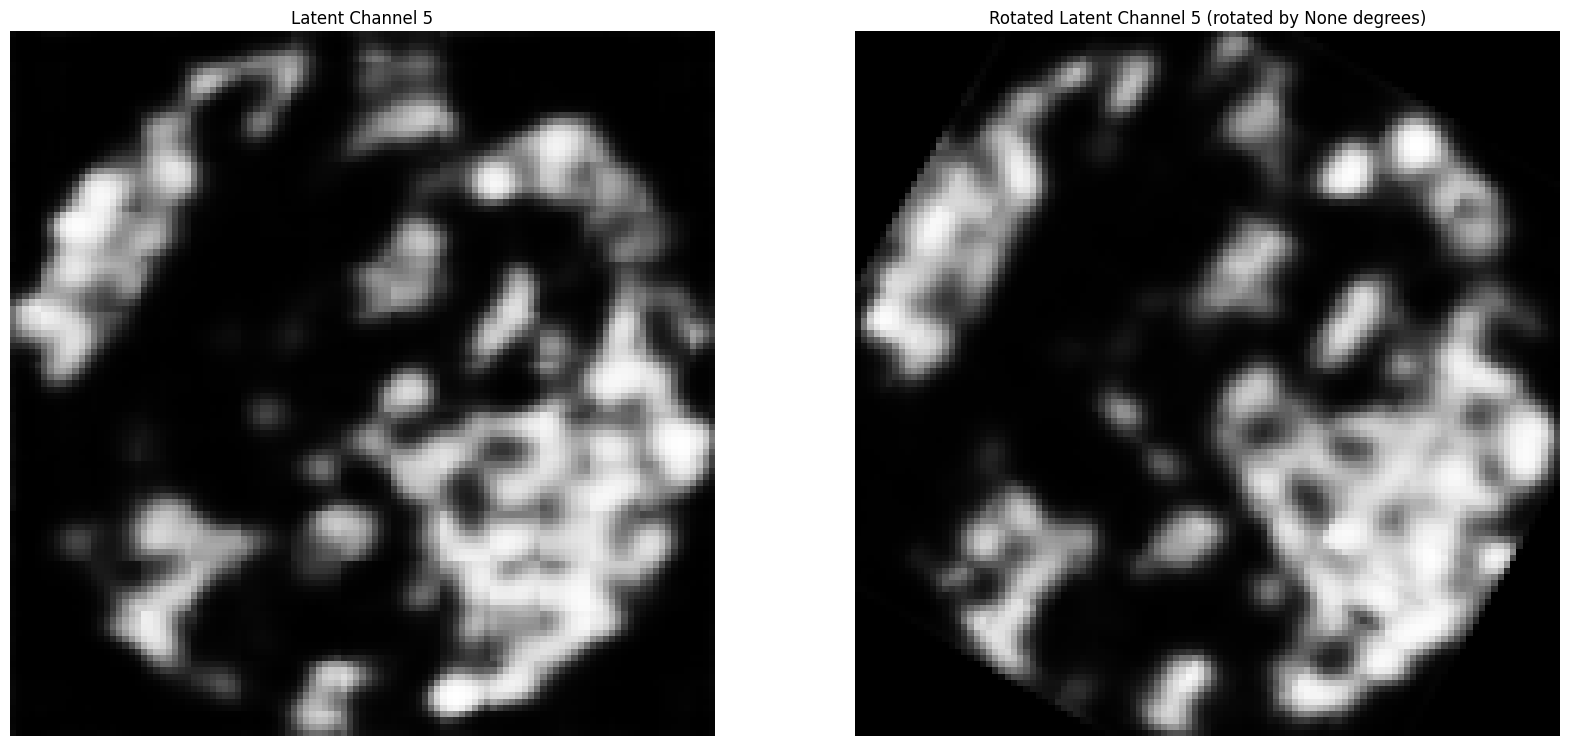

In [211]:
def plot_latents_continous(all_results, idx, rotation=90,channel_idx=0, layer="latent"):
    if rotation % 90 != 0:
        latent = all_results[idx]["r0_nf_mask"][layer]
    else:
        latent = all_results[idx]["r0_nf"][layer]
    latent_rot = all_results[idx][f"r{rotation}_nf"][layer]
    print(latent.shape, latent_rot.shape)
    
    if rotation % 90 == 0:
        latent_rot_back = torch.rot90(torch.tensor(latent_rot), k=-rotation // 90, dims=(-2, -1))
    else:
        latent_rot_back = rotate_tensor(torch.tensor(latent_rot), -rotation, mode='bilinear')
    print(latent_rot_back.shape)
    channel_idx = channel_idx
    plot_latents(latent, latent_rot_back, rotation=None, layer_idx=-1, chanel_idx=channel_idx)

plot_latents_continous(all_results, idx=0, rotation=30, channel_idx=5, layer="reconstruction")


(40, 113, 113) (40, 113, 113)
torch.Size([40, 113, 113])
Latent shape: (1, 40, 113, 113), Rotated latent shape: torch.Size([1, 40, 113, 113])
No rotation applied
Equivariance Error (MSE) for channel 5: 0.0018904628232121468


/tmp/ipykernel_178767/2765757990.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_latent = torch.tensor(rotated_output)


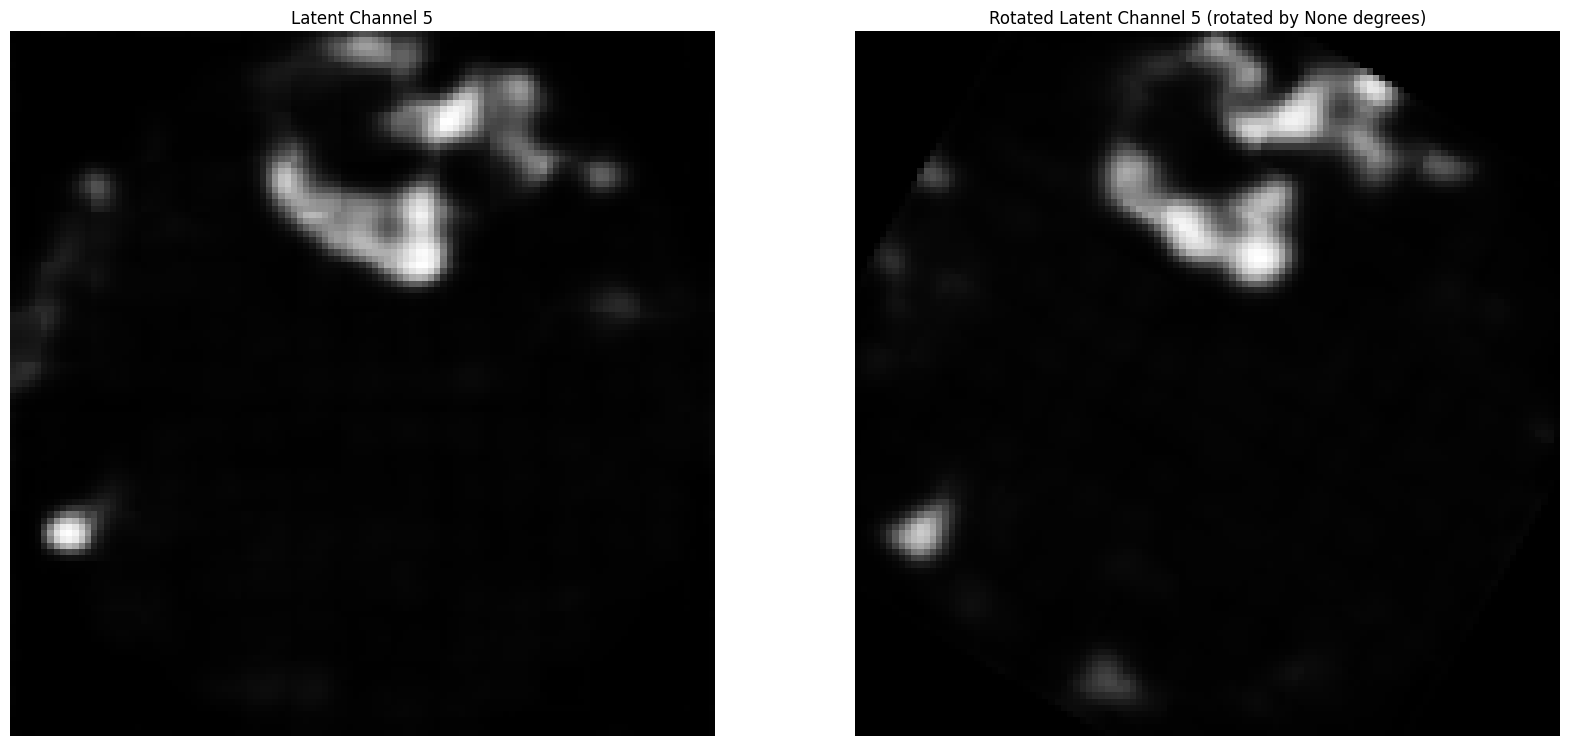

In [ ]:
plot_latents_continous(all_results, idx=0, rotation=30, channel_idx=5, layer="reconstruction")

(40, 113, 113) (40, 113, 113)
Latent shape: (1, 40, 113, 113), Rotated latent shape: torch.Size([1, 40, 113, 113])
No rotation applied
Equivariance Error (MSE) for channel 5: 0.010623707436025143


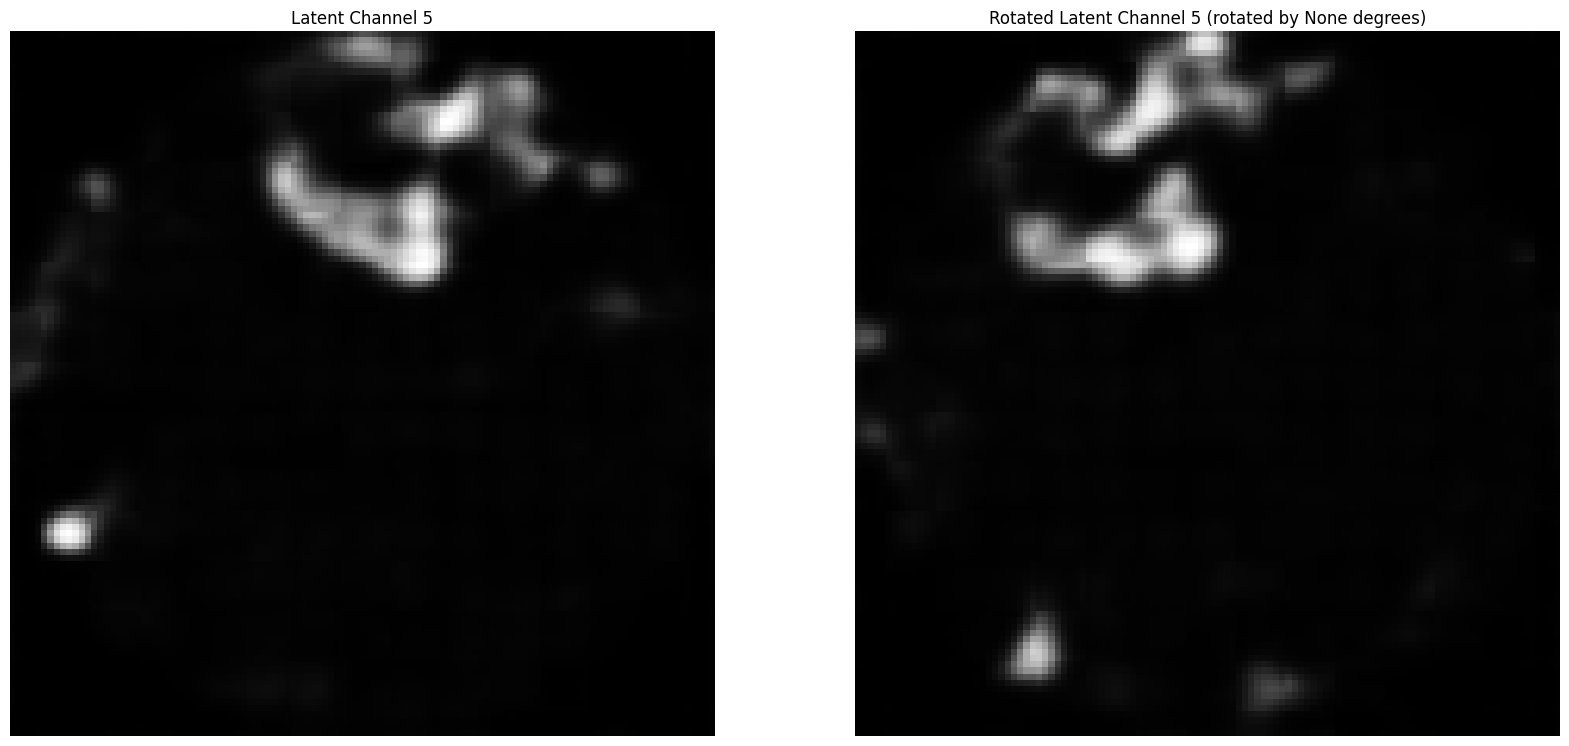

In [59]:
plot_latents_continous(all_results, idx=0, rotation=30, channel_idx=5, layer="reconstruction")

Latent shape: (1, 512, 15, 15), Rotated latent shape: torch.Size([1, 512, 15, 15])
Equivariance Error (MSE) for channel 0: 1.511541313448106e-06


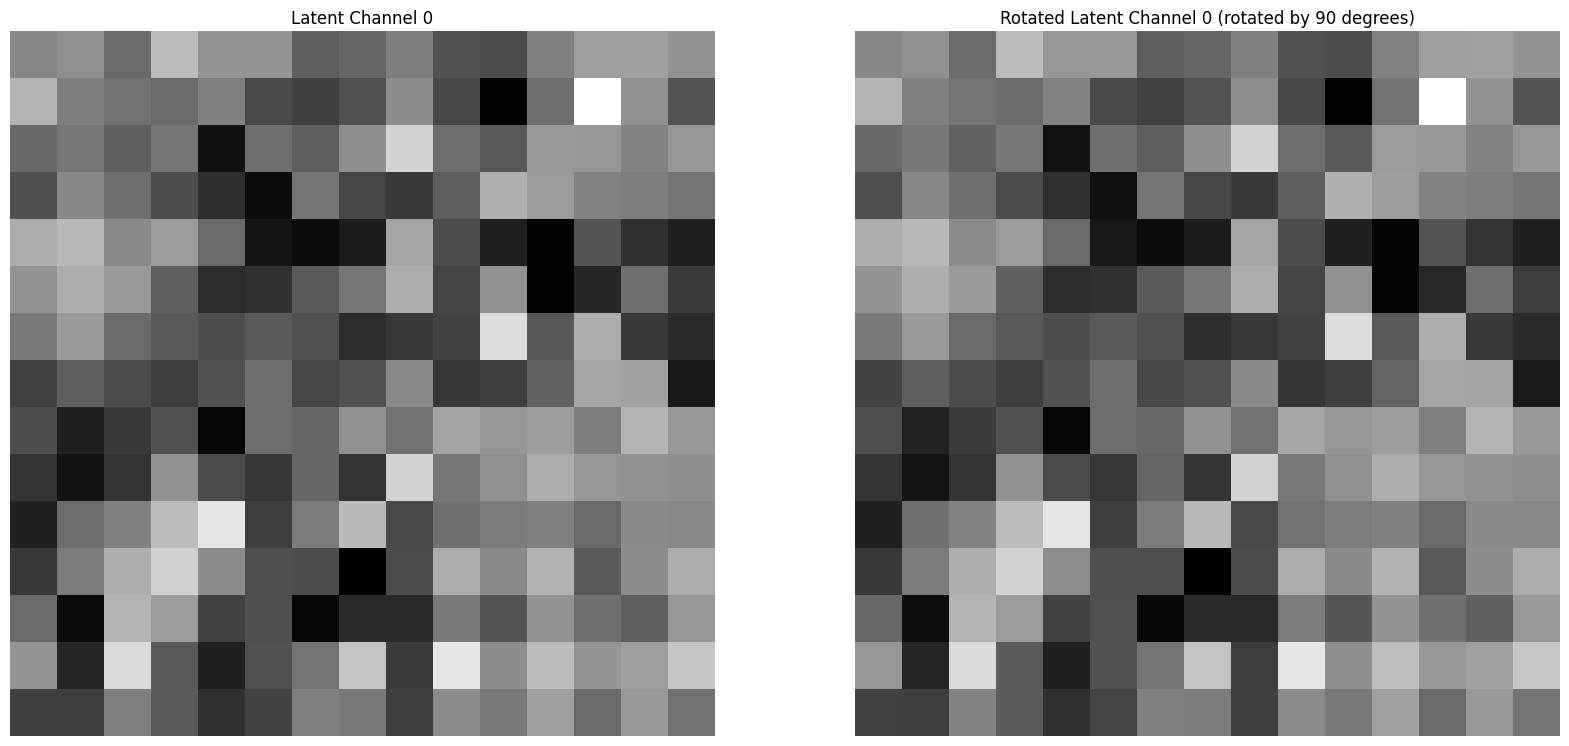

In [192]:
def plot_latents(output, rotated_output, rotation=90, layer_idx=-1, chanel_idx=0):
    if isinstance(output, dict):
        print("Output is a dict")
        latent = output["features"][layer_idx].detach().cpu().numpy()
        rotated_latent = rotated_output["features"][layer_idx].detach().cpu()
    else:
        latent = output
        rotated_latent = torch.tensor(rotated_output)
    print( f"Latent shape: {latent.shape}, Rotated latent shape: {rotated_latent.shape}")
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(latent[0, chanel_idx], cmap='gray')
    plt.title(f'Latent Channel {chanel_idx}')
    plt.axis('off')

    # rotated_latent_rotated_back = torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    if rotation is not None:
        rotated_latent_rotated_back = torch.rot90(rotated_latent, k=-rotation // 90, dims=(-2, -1)) if rotation % 90 == 0 else torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    else:
        print("No rotation applied")
        rotated_latent_rotated_back = rotated_latent

    rotated_latent_rotated_back = rotated_latent_rotated_back.numpy()
    plt.subplot(1, 2, 2)
    plt.imshow(rotated_latent_rotated_back[0, chanel_idx], cmap='gray')
    plt.title(f'Rotated Latent Channel {chanel_idx} (rotated by {rotation} degrees)')
    plt.axis('off')

    equivariance_error = np.square(latent - rotated_latent_rotated_back).mean().item()
    print(f'Equivariance Error (MSE) for channel {chanel_idx}: {equivariance_error}')

    plt.show()

idx = 0
plot_latents(all_results[idx]["r0_nf"]["latent"][np.newaxis], all_results[idx]["r90_nf"]["latent"][np.newaxis], rotation=90, chanel_idx=0)

Latent shape: (1, 512, 15, 15), Rotated latent shape: torch.Size([1, 512, 15, 15])
Equivariance Error (MSE) for channel 0: 1.511541313448106e-06


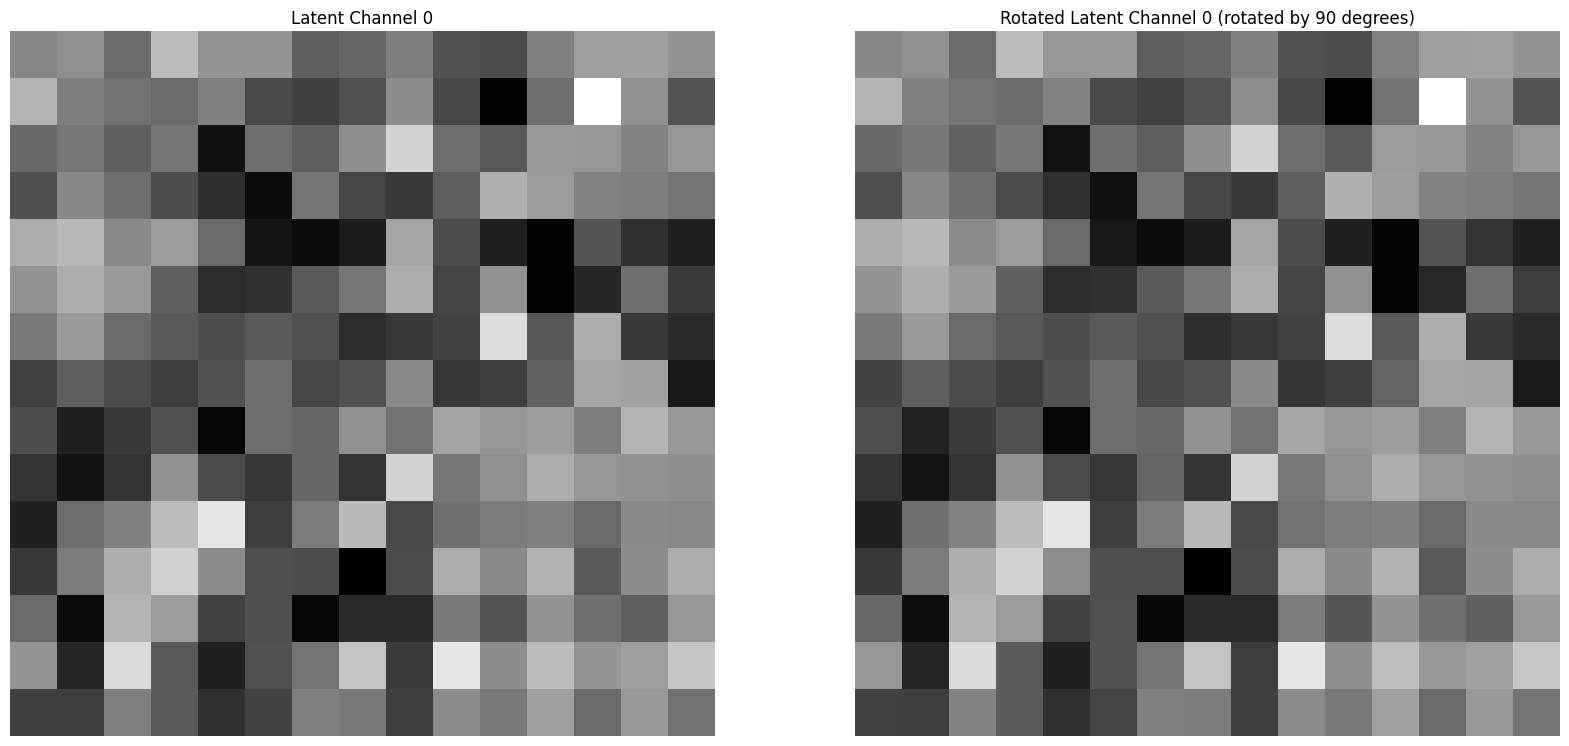

In [22]:
def plot_latents(output, rotated_output, rotation=90, layer_idx=-1, chanel_idx=0):
    if isinstance(output, dict):
        print("Output is a dict")
        latent = output["features"][layer_idx].detach().cpu().numpy()
        rotated_latent = rotated_output["features"][layer_idx].detach().cpu()
    else:
        latent = output
        rotated_latent = torch.tensor(rotated_output)
    print( f"Latent shape: {latent.shape}, Rotated latent shape: {rotated_latent.shape}")
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(latent[0, chanel_idx], cmap='gray')
    plt.title(f'Latent Channel {chanel_idx}')
    plt.axis('off')

    # rotated_latent_rotated_back = torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    if rotation is not None:
        rotated_latent_rotated_back = torch.rot90(rotated_latent, k=-rotation // 90, dims=(-2, -1)) if rotation % 90 == 0 else torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    else:
        print("No rotation applied")
        rotated_latent_rotated_back = rotated_latent

    rotated_latent_rotated_back = rotated_latent_rotated_back.numpy()
    plt.subplot(1, 2, 2)
    plt.imshow(rotated_latent_rotated_back[0, chanel_idx], cmap='gray')
    plt.title(f'Rotated Latent Channel {chanel_idx} (rotated by {rotation} degrees)')
    plt.axis('off')

    equivariance_error = np.square(latent - rotated_latent_rotated_back).mean().item()
    print(f'Equivariance Error (MSE) for channel {chanel_idx}: {equivariance_error}')

    plt.show()

idx = 0
plot_latents(all_results[idx]["r0_nf"]["latent"][np.newaxis], all_results[idx]["r90_nf"]["latent"][np.newaxis], rotation=90, chanel_idx=0)

In [68]:
plot_latents(all_results[idx]["r0_nf"]["latent"][np.newaxis], all_results[idx]["r90_nf"]["latent"][np.newaxis], rotation=90, chanel_idx=0)

IndexError: list index out of range

(512, 15, 15) (512, 15, 15)
Latent shape: (1, 512, 15, 15), Rotated latent shape: torch.Size([1, 512, 15, 15])
No rotation applied
Equivariance Error (MSE) for channel 0: 0.012725861743092537


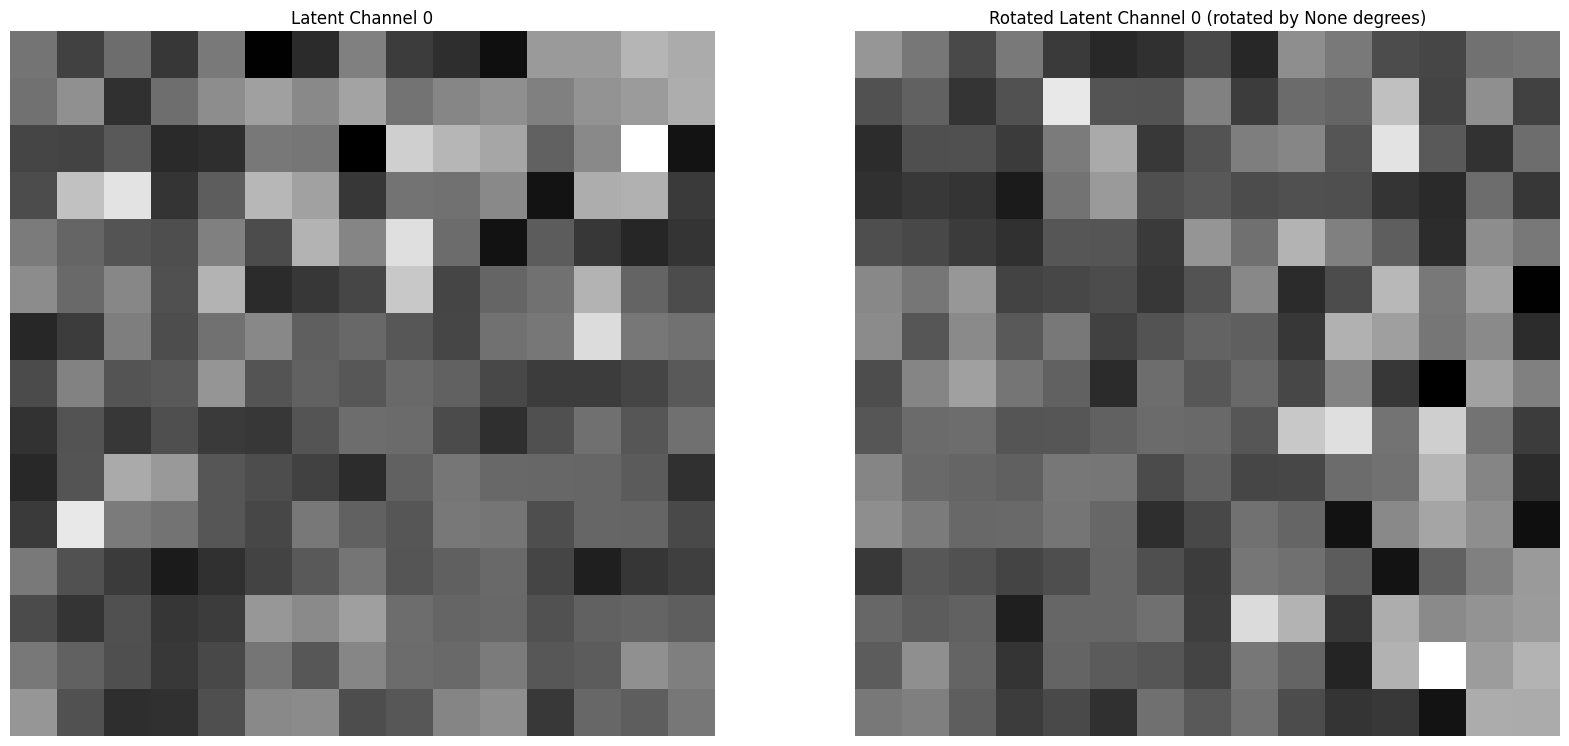

In [69]:
plot_latents_continous(all_results, idx=0, rotation=90, channel_idx=0, layer="latent")

(40, 113, 113) (40, 113, 113)
torch.Size([40, 113, 113])
Latent shape: (1, 40, 113, 113), Rotated latent shape: torch.Size([1, 40, 113, 113])
No rotation applied
Equivariance Error (MSE) for channel 0: 0.0013330202782526612


/tmp/ipykernel_178767/2765757990.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_latent = torch.tensor(rotated_output)


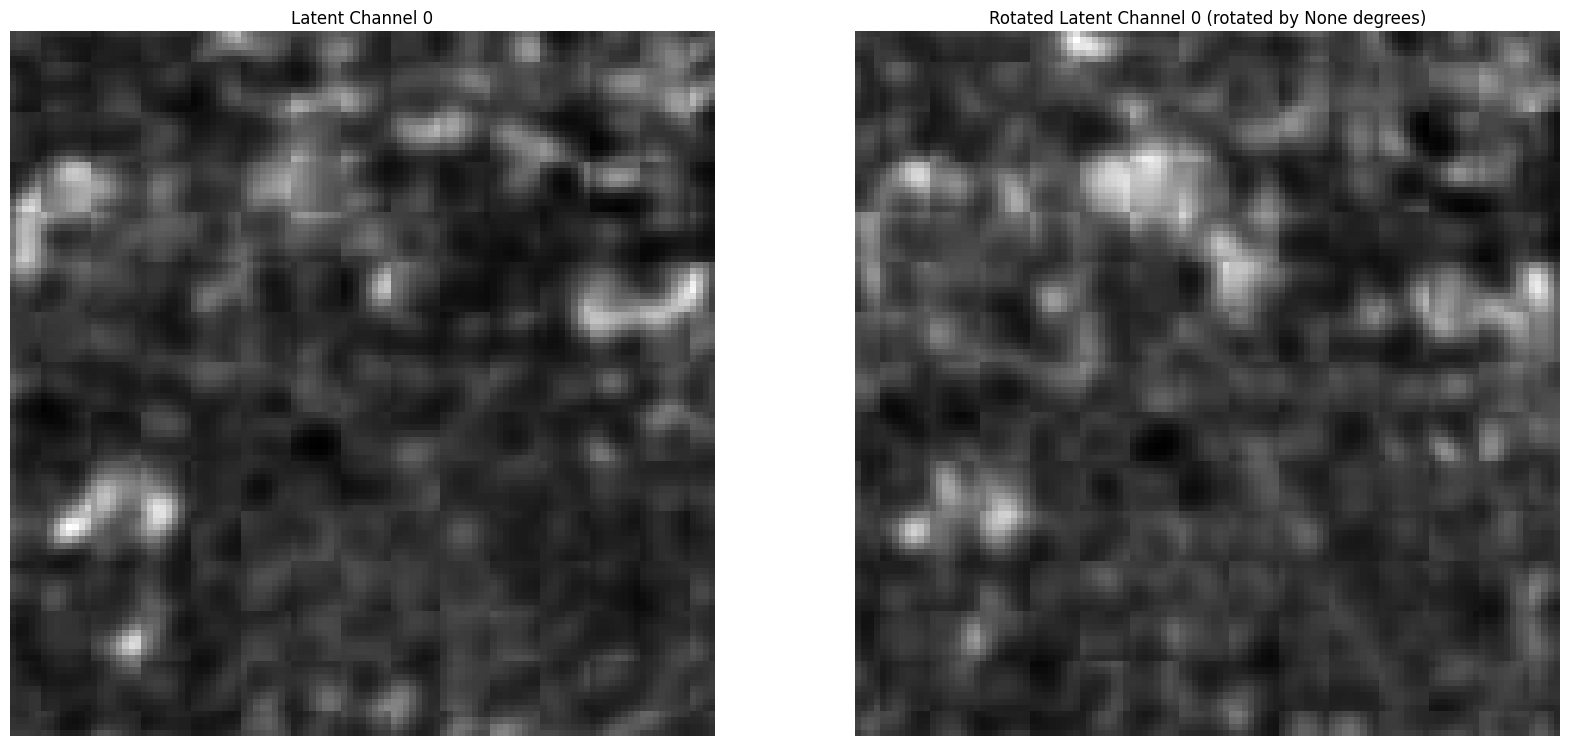

In [ ]:
plot_latents_continous(all_results, idx=0, rotation=90, channel_idx=0, layer="reconstruction")

Latent shape: (1, 40, 113, 113), Rotated latent shape: torch.Size([1, 40, 113, 113])
Equivariance Error (MSE) for channel 5: 0.0016655452782288194


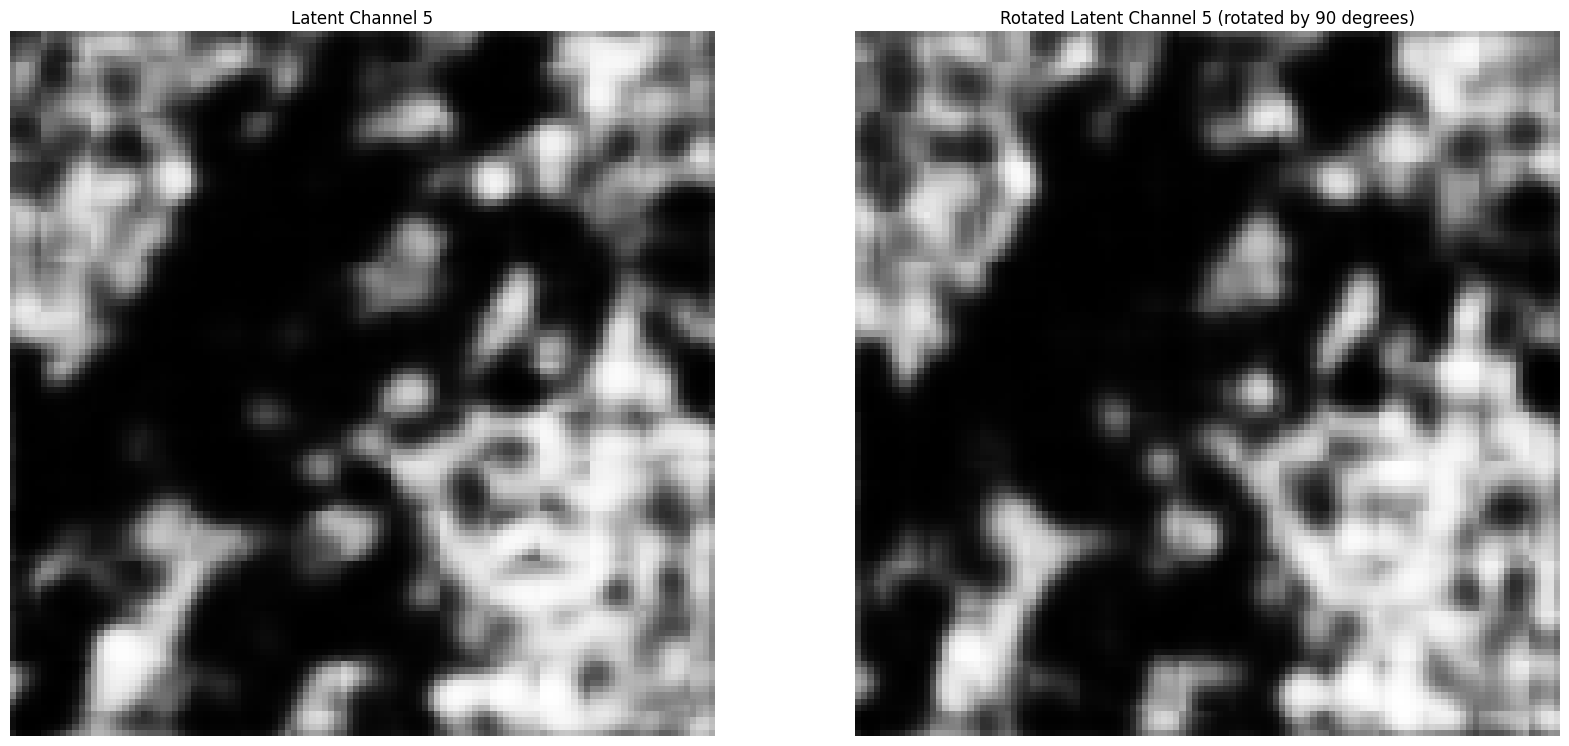

In [174]:
plot_latents(all_results[idx]["r0_nf"]["reconstruction"][np.newaxis], all_results[idx]["r90_nf"]["reconstruction"][np.newaxis], rotation=90, chanel_idx=5)

In [151]:
# get results for path: 
all_results = []
# path = "/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10022152-LUNG-VAR-TIS-01-IMC-01_002.tiff"
path = "/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10018884-LUNG-VAR-TIS-01-IMC-01_002.tiff"
dataset = "nsclc2-panel1"
key = (path, dataset)
idx = test_dataloader.dataset.imgs.index(key)

org_image, channel_ids, panel_idx, img_path = test_dataloader.dataset[idx]
print(img_path, org_image.shape, channel_ids, panel_idx)
org_image = torch.tensor(org_image).unsqueeze(0)
channel_ids = torch.tensor(channel_ids).unsqueeze(0)
# panel_idx = torch.tensor([panel_idx])
img_path = [img_path]
results = eval(org_image=org_image, channel_ids=channel_ids, panel_idx=panel_idx, img_path=img_path)
all_results.append(results)



/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10018884-LUNG-VAR-TIS-01-IMC-01_002.tiff (40, 113, 113) tensor([ 1, 17, 14, 16,  2,  9, 33,  8, 38, 34, 12,  5, 37, 28, 29, 19, 24, 36,
        30, 20, 10,  4, 26, 18, 23, 11,  6,  3, 13, 15, 31, 21, 39,  7, 35, 25,
        27,  0, 22, 32]) nsclc2-panel1
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')


/tmp/ipykernel_1693614/742109121.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel_ids = torch.tensor(channel_ids).unsqueeze(0)


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 3

In [76]:
all_results[0].keys()

dict_keys(['r0_nf', 'img_path', 'r0_f', 'r90_nf', 'r90_f', 'r180_nf', 'r180_f', 'r270_nf', 'r270_f'])

In [77]:
all_results[0]["img_path"]

('/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10018890-LUNG-VAR-TIS-01-IMC-01_002.tiff',
 '/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10018890-LUNG-VAR-TIS-01-IMC-01_004.tiff',
 '/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210921_LUNG_10041537-LUNG-VAR-TIS-01-IMC-01_001.tiff',
 '/home/szlukasik/immu-vis/data/immuvis_all2/test/nsclc2-panel1/imgs/IMMUcan_Batch20210701_LUNG_10020790-LUNG-VAR-TIS-01-IMC-01_002.tiff')

In [78]:
all_results[0]["r0_nf"].keys()

dict_keys(['latent', 'reconstruction'])

In [144]:
all_results_concat = [
    {
        k: {
            h: all_results[i][k][h][j] for h in all_results[i]["r0_nf"].keys()
        } for k in all_results[i].keys()
    } for i in range(len(all_results)) for j in range(all_results[i]["r0_nf"]["latent"].shape[0])
]
all_results = all_results_concat

In [106]:
len(all_results_concat)

1

In [44]:
len(all_results[0].keys())

9

In [31]:
all_results_first_10 = all_results[:72]
import pickle
with open("embeddings/test_2.pkl", "wb") as f:
    pickle.dump(all_results_first_10, f)

In [29]:
with open("embeddings/test_10.pkl", "rb") as f:
    all_results_first_10 = pickle.load(f)
len(all_results_first_10)

360

In [27]:
len(set([r["img_path"] for r in all_results_first_10]))

10

In [28]:
all_results_first_10 = all_results[:361]
len(set([r["img_path"] for r in all_results_first_10]))

11

In [20]:
19728 / (4644)

4.248062015503876

In [302]:
torch.square(all_results_debug[0]["r0_nf"] - output["features"][-1].cpu().detach()[0]).mean()

tensor(0.1901)

In [285]:
channel_ids.shape

torch.Size([1, 40])

In [16]:
all_results[0].keys()

dict_keys(['r0_nf', 'img_path', 'r0_f', 'r90_nf', 'r90_f', 'r180_nf', 'r180_f', 'r270_nf', 'r270_f'])

In [12]:
all_results[0]["r0_nf"].shape

(13, 13)

In [48]:
def compute_equivariance_error(all_results, idx=0):
    errors = []
    org_latent = all_results[idx]["r0_nf"]
    for rotation in [0, 90, 180, 270]:
        for flip in [False, True]:
            key = f"r{rotation}" + ("_f" if flip else "_nf")
            if key not in all_results[idx]:
                continue
            lat = all_results[idx][key]
            print(f"lat {lat.shape}")
            if flip:
                print("flipping")
                lat = np.flip(lat, axis=2)
            if rotation > 0:
                print(f"rotating {rotation} back")
                lat = np.rot90(lat, k=-rotation // 90, axes=(1, 2))
            error = np.square(org_latent - lat).mean()
            errors.append(error)
            print(f"Errors for {key}: {error}")

    return errors

compute_equivariance_error(all_results, idx=0)


lat (512, 15, 15)
Errors for r0_nf: 0.0
lat (512, 15, 15)
flipping
Errors for r0_f: 0.004553571809083223
lat (512, 15, 15)
rotating 90 back
Errors for r90_nf: 1.3196022337069735e-06
lat (512, 15, 15)
flipping
rotating 90 back
Errors for r90_f: 0.004553029779344797
lat (512, 15, 15)
rotating 180 back
Errors for r180_nf: 1.3159227592041134e-06
lat (512, 15, 15)
flipping
rotating 180 back
Errors for r180_f: 0.0045545510947704315
lat (512, 15, 15)
rotating 270 back
Errors for r270_nf: 1.2757559488818515e-06
lat (512, 15, 15)
flipping
rotating 270 back
Errors for r270_f: 0.0045523871667683125


[0.0,
 0.004553572,
 1.3196022e-06,
 0.00455303,
 1.3159228e-06,
 0.004554551,
 1.275756e-06,
 0.004552387]

In [313]:
compute_equivariance_error(all_results_debug, idx=0)


lat torch.Size([512, 13, 13])
Errors for r0_nf: 0.0
lat torch.Size([512, 13, 13])
flipping


ValueError: step must be greater than zero

In [311]:
compute_equivariance_error(all_results_debug, idx=0)


lat torch.Size([512, 13, 13])
Errors for r0_nf: 0.0
lat torch.Size([512, 13, 13])
rotating 90 back
Errors for r90_nf: 3.381205905539364e-13


[tensor(0.), tensor(3.3812e-13)]

In [24]:
def compute_equivariance_error_torch(all_results, idx=0):
    errors = []
    org_latent = all_results[idx]["r0_nf"]
    for rotation in [0, 90, 180, 270]:
        for flip in [False, True]:
            key = f"r{rotation}" + ("_f" if flip else "_nf")
            if key not in all_results[idx]:
                continue
            lat = all_results[idx][key]
            print(f"lat {lat.shape}")
            if flip:
                print("flipping")
                lat = torch.flip(lat, dims=[2])
            if rotation > 0:
                print(f"rotating {rotation} back")
                lat = torch.rot90(lat, k=-rotation // 90, dims=(1, 2))
            error = torch.square(org_latent - lat).mean().item()
            errors.append(error)
            print(f"Errors for {key}: {error}")

    return errors
compute_equivariance_error_torch(all_results, idx=0)

lat torch.Size([512, 15, 15])
Errors for r0_nf: 0.0
lat torch.Size([512, 15, 15])
flipping
Errors for r0_f: 0.004547119140625
lat torch.Size([512, 15, 15])
rotating 90 back
Errors for r90_nf: 1.3187527656555176e-06
lat torch.Size([512, 15, 15])
flipping
rotating 90 back
Errors for r90_f: 0.004547119140625
lat torch.Size([512, 15, 15])
rotating 180 back
Errors for r180_nf: 1.3187527656555176e-06
lat torch.Size([512, 15, 15])
flipping
rotating 180 back
Errors for r180_f: 0.004547119140625
lat torch.Size([512, 15, 15])
rotating 270 back
Errors for r270_nf: 1.2740492820739746e-06
lat torch.Size([512, 15, 15])
flipping
rotating 270 back
Errors for r270_f: 0.004547119140625


[0.0,
 0.004547119140625,
 1.3187527656555176e-06,
 0.004547119140625,
 1.3187527656555176e-06,
 0.004547119140625,
 1.2740492820739746e-06,
 0.004547119140625]

In [219]:
len(output["features"])

4

In [232]:
results_debug = {
    "r0_nf": output["features"][-1].cpu().detach().numpy()[0],
    "r90_nf": rotated_output["features"][-1].cpu().detach().numpy()[0]
}
compute_equivariance_error([results_debug], idx=0)

lat (512, 13, 13)
Errors for r0_nf: 0.0
lat (512, 13, 13)
rotating 90 back
Errors for r90_nf: 3.338117813850988e-13


[0.0, 3.3381178e-13]

In [65]:
all_results[0].keys()

dict_keys(['r0_nf', 'img_path', 'r0_f', 'r90_nf', 'r90_f', 'r180_nf', 'r180_f', 'r270_nf', 'r270_f'])

In [69]:
all_results[0]["r0_nf"]["latent"].shape

(4, 512, 15, 15)

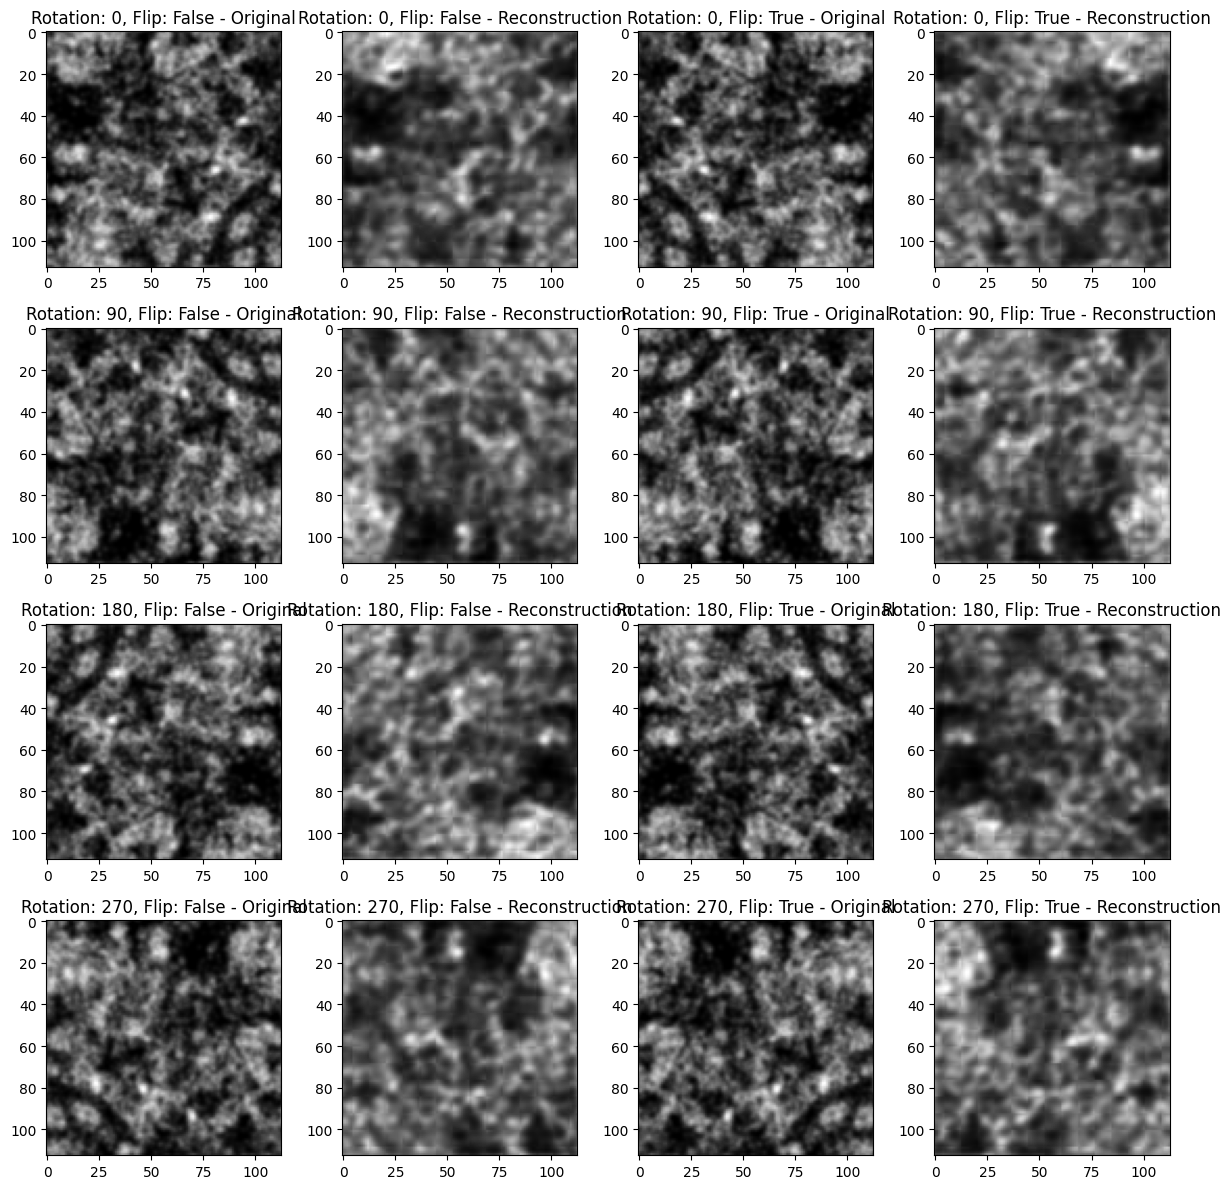

In [ ]:

fig = plot_reconstructions(all_results, idx=6, channel_idx=1)


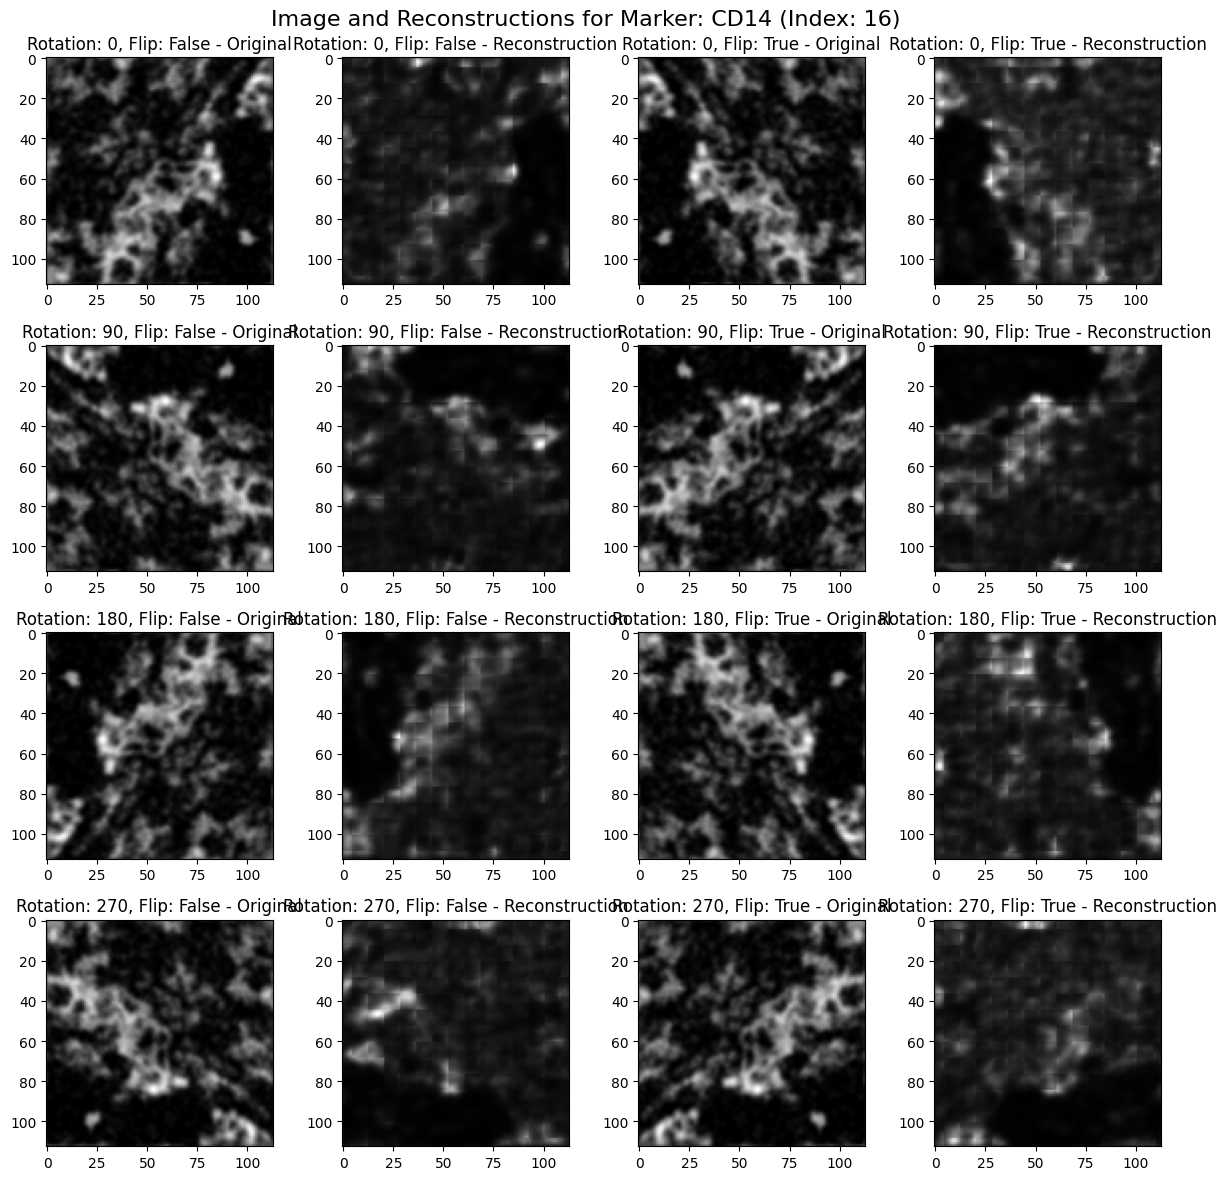

In [116]:
def plot_reconstructions(all_results, idx=0, channel_idx=0):
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    for i, rotation in enumerate([0, 90, 180, 270]):
        for j, flip in enumerate([False, True]):
            key = f"r{rotation}" + ("_f" if flip else "_nf")
            img = all_results[idx][key]["img"][channel_idx]
            recon = all_results[idx][key]["reconstruction"][channel_idx]
            axs[i, j*2].imshow(img, cmap='gray')
            axs[i, j*2].set_title(f"Rotation: {rotation}, Flip: {flip} - Original")
            axs[i, j*2+1].imshow(recon, cmap='gray')
            axs[i, j*2+1].set_title(f"Rotation: {rotation}, Flip: {flip} - Reconstruction")
    marker_name = INV_TOKENIZER[channel_idx]
    fig.suptitle(f"Image and Reconstructions for Marker: {marker_name} (Index: {channel_idx})", fontsize=16)
    plt.tight_layout()
    plt.show()
    return fig
fig = plot_reconstructions(all_results, idx=0, channel_idx=TOKENIZER["CD14"])

In [130]:
TOKENIZER

{'SMA': 0,
 'B2M': 1,
 'CD15': 2,
 'Histone H3': 3,
 'cl.PARP': 4,
 'CD303': 5,
 'GrzB': 6,
 'MPO': 7,
 'CD20': 8,
 'CD16': 9,
 'CD8a': 10,
 'FOXP3': 11,
 'CD3': 12,
 'HLADR': 13,
 'CD11c': 14,
 'ICOS': 15,
 'CD14': 16,
 'Carbonic Anhydrase': 17,
 'DNA2': 18,
 'CD40': 19,
 'CD7': 20,
 'Ki67': 21,
 'TCF7': 22,
 'Ecad': 23,
 'CD45RA': 24,
 'PDGFRb': 25,
 'DNA1': 26,
 'PDL1': 27,
 'CD38': 28,
 'CD4': 29,
 'CD68': 30,
 'Ido1': 31,
 'VISTA': 32,
 'CD163': 33,
 'CD27': 34,
 'PD1': 35,
 'CD45RO': 36,
 'CD33': 37,
 'CD206': 38,
 'LAG3': 39}

In [ ]:

#   nsclc2-panel1:
#   - B2M
#   - Carbonic Anhydrase
#   - CD11c
#   - CD14
#   - CD15
#   - CD16
#   - CD163
#   - CD20
#   - CD206
#   - CD27
#   - CD3
#   - CD303
#   - CD33
#   - CD38
#   - CD4
#   - CD40
#   - CD45RA
#   - CD45RO
#   - CD68
#   - CD7
#   - CD8a
#   - cl.PARP
#   - DNA1
#   - DNA2
#   - Ecad
#   - FOXP3
#   - GrzB
#   - Histone H3
#   - HLADR
#   - ICOS
#   - Ido1
#   - Ki67
#   - LAG3
#   - MPO
#   - PD1
#   - PDGFRb
#   - PDL1
#   - SMA
#   - TCF7
#   - VISTA


TypeError: Invalid shape (40, 113, 113) for image data

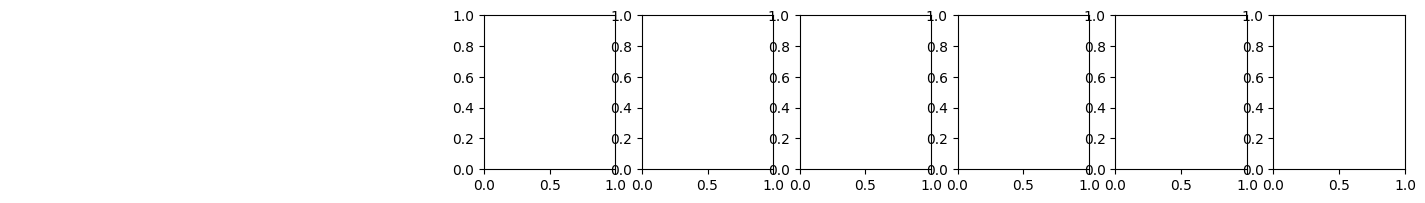

In [152]:
from multiplex_model.utils import ClampWithGrad, plot_reconstructs_with_uncertainty, get_scheduler_with_warmup

masked_img = torch.from_numpy(all_results[0]["r0_nf"]["img"]).unsqueeze(0)
mi = torch.from_numpy(all_results[0]["r0_nf"]["reconstruction"]).unsqueeze(0)
uncertainty_img = torch.from_numpy(all_results[0]["r0_nf"]["logsigma"]).unsqueeze(0).exp()
unactive_channels = []
channel_ids = np.array([np.arange(len(TOKENIZER))])
reconstr_img = plot_reconstructs_with_uncertainty(
    masked_img,
    mi,
    uncertainty_img,
    channel_ids,
    unactive_channels,
    markers_names_map=INV_TOKENIZER,
    scale_by_max=True
)

In [146]:
TOKENIZER

{'SMA': 0,
 'B2M': 1,
 'CD15': 2,
 'Histone H3': 3,
 'cl.PARP': 4,
 'CD303': 5,
 'GrzB': 6,
 'MPO': 7,
 'CD20': 8,
 'CD16': 9,
 'CD8a': 10,
 'FOXP3': 11,
 'CD3': 12,
 'HLADR': 13,
 'CD11c': 14,
 'ICOS': 15,
 'CD14': 16,
 'Carbonic Anhydrase': 17,
 'DNA2': 18,
 'CD40': 19,
 'CD7': 20,
 'Ki67': 21,
 'TCF7': 22,
 'Ecad': 23,
 'CD45RA': 24,
 'PDGFRb': 25,
 'DNA1': 26,
 'PDL1': 27,
 'CD38': 28,
 'CD4': 29,
 'CD68': 30,
 'Ido1': 31,
 'VISTA': 32,
 'CD163': 33,
 'CD27': 34,
 'PD1': 35,
 'CD45RO': 36,
 'CD33': 37,
 'CD206': 38,
 'LAG3': 39}

In [147]:
channel_ids

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39]])

In [150]:
len(all_results)

1

torch.Size([1, 40, 113, 113]) torch.Size([1, 40, 113, 113]) torch.Size([1, 40, 113, 113]) [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]]


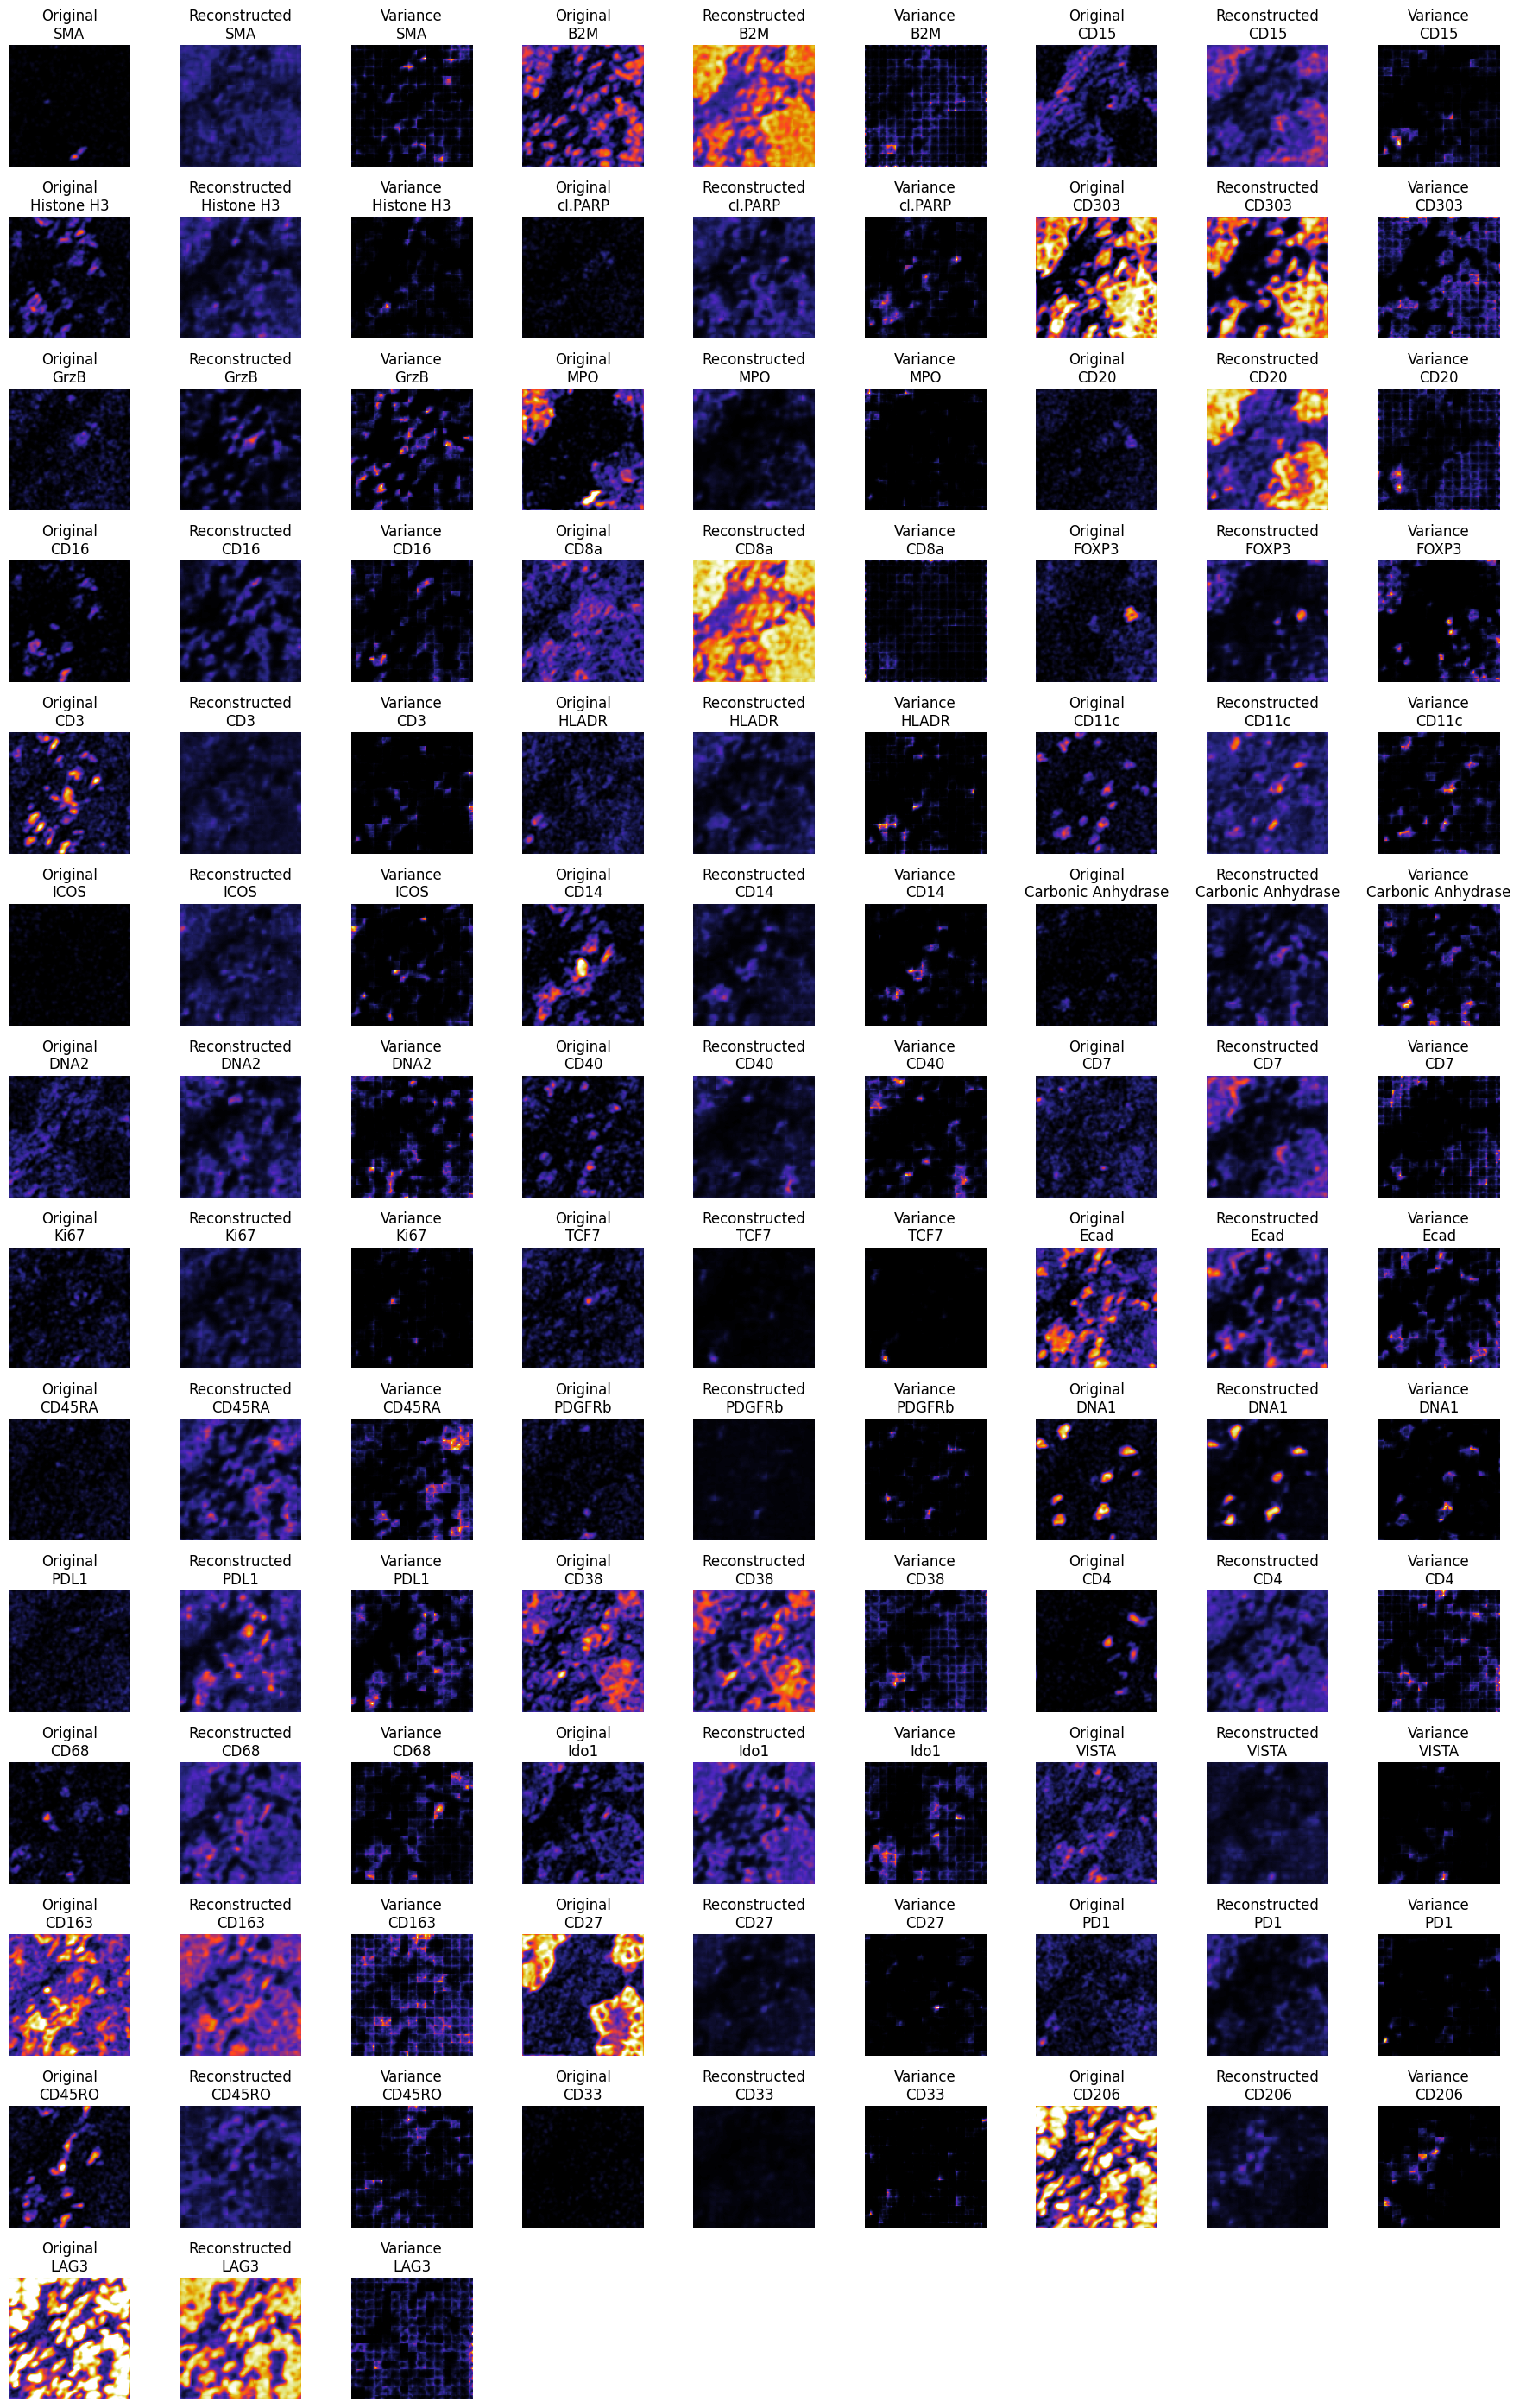

In [ ]:
from multiplex_model.utils import ClampWithGrad, plot_reconstructs_with_uncertainty, get_scheduler_with_warmup

masked_img = torch.from_numpy(all_results[0]["r0_nf"]["img"])
mi = torch.from_numpy(all_results[0]["r0_nf"]["reconstruction"])
uncertainty_img = torch.from_numpy(all_results[0]["r0_nf"]["logsigma"]).exp()
unactive_channels = []
channel_ids = np.array([np.arange(len(TOKENIZER))])
print(masked_img.shape, mi.shape, uncertainty_img.shape, channel_ids)
reconstr_img = plot_reconstructs_with_uncertainty(
    masked_img,
    mi,
    uncertainty_img,
    channel_ids,
    unactive_channels,
    markers_names_map=INV_TOKENIZER,
    scale_by_max=True
)

In [128]:
channel_ids

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39]])

In [109]:
INV_TOKENIZER

{0: 'SMA',
 1: 'B2M',
 2: 'CD15',
 3: 'Histone H3',
 4: 'cl.PARP',
 5: 'CD303',
 6: 'GrzB',
 7: 'MPO',
 8: 'CD20',
 9: 'CD16',
 10: 'CD8a',
 11: 'FOXP3',
 12: 'CD3',
 13: 'HLADR',
 14: 'CD11c',
 15: 'ICOS',
 16: 'CD14',
 17: 'Carbonic Anhydrase',
 18: 'DNA2',
 19: 'CD40',
 20: 'CD7',
 21: 'Ki67',
 22: 'TCF7',
 23: 'Ecad',
 24: 'CD45RA',
 25: 'PDGFRb',
 26: 'DNA1',
 27: 'PDL1',
 28: 'CD38',
 29: 'CD4',
 30: 'CD68',
 31: 'Ido1',
 32: 'VISTA',
 33: 'CD163',
 34: 'CD27',
 35: 'PD1',
 36: 'CD45RO',
 37: 'CD33',
 38: 'CD206',
 39: 'LAG3'}

In [ ]:
len(test_dataloader.dataset.image_paths)

In [ ]:
test_dataloader.dataset.curr_image_idx

In [ ]:
len(all_results)

In [ ]:
sys.getsizeof(all_results[0]["r0_nf"]["latent"])

In [ ]:
all_results[0]["r0_nf"]["latent"].dtype

In [ ]:
all_results[0]["r0_nf"]["latent"].shape

In [ ]:
4 * 512 * 13 * 13 * 8 * 4644 / (1024 ** 3)

In [ ]:
144 * 8 * 4644 / 1024 / 1024

In [ ]:
import pickle
with open("embeddings/test.pkl", "wb") as f:
    pickle.dump(all_results, f)

In [ ]:
all_image_paths = [path for _ in range(36) for path in test_dataloader.dataset.image_paths]
len(all_image_paths)

In [ ]:
all_results[0].keys()

In [ ]:
for e, path in zip(all_results, all_image_paths):
    for key in e.keys():
        e[key] = e[key]["latent"]
    e["image_path"] = path


In [ ]:
torch.save(all_results[0]["r0_nf"]["latent"], "embeddings/test_tensor.pt")

In [ ]:
sys.getsizeof(all_results[0]["r0_f"])  # size in GB

In [ ]:
232 * 8 * 4644 / 1024 / 1024

In [ ]:
all_results[0].keys()

In [ ]:
def plot_image(img, channel_idx, title="Image"):
    plt.imshow(img[channel_idx])
    plt.title(title)
    plt.axis("off")
    plt.show()
plot_image(all_results[0]['r0_f']['img'][0], channel_idx=0, title="Original Image")

In [ ]:
plot_image(all_results[0]['r90_f']['img'][0], channel_idx=0, title="Original Image")

In [163]:
plot_image(all_results[0]['r90_f']['reconstruction'][0], channel_idx=0, title="Reconstructed Image")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
reconstructions[:, :, 3:-4, 3:-4].shape

In [ ]:
type(features)

In [ ]:
len(features)

In [ ]:
for f in features:
    print(f.shape)

In [293]:
import torchvision
ROTATION = 90
# rotated_img = torchvision.transforms.functional.rotate(img, ROTATION)
# RuntimeError: Input type (double) and bias type (float) should be the same
rotated_img = torch.rot90(masked_img, k=ROTATION // 90, dims=(-2, -1)).to(dtype=torch.float32)

with torch.no_grad():
    rotated_output = model(rotated_img, active_channel_ids, channel_ids, True)
    rotated_features = rotated_output["features"]
    rotated_reconstructions = rotated_output["output"]
rotated_mi, rotated_logsigma = rotated_reconstructions.unbind(dim=-1)
rotated_mi = torch.sigmoid(rotated_mi)


Latent shape: torch.Size([1, 512, 13, 13])


In [295]:
import torchvision
ROTATION = 90
# rotated_img = torchvision.transforms.functional.rotate(img, ROTATION)
# RuntimeError: Input type (double) and bias type (float) should be the same
rotated_img = torch.rot90(img, k=ROTATION // 90, dims=(-2, -1)).to(dtype=torch.float32)

with torch.no_grad():
    rotated_output = model(rotated_img, channel_ids, channel_ids, True)
    rotated_features = rotated_output["features"]
    rotated_reconstructions = rotated_output["output"]
rotated_mi, rotated_logsigma = rotated_reconstructions.unbind(dim=-1)
rotated_mi = torch.sigmoid(rotated_mi)


Latent shape: torch.Size([1, 512, 13, 13])


In [ ]:
rotated_reconstructions.shape

Latent shape: torch.Size([1, 512, 13, 13]), Rotated latent shape: torch.Size([1, 512, 13, 13])


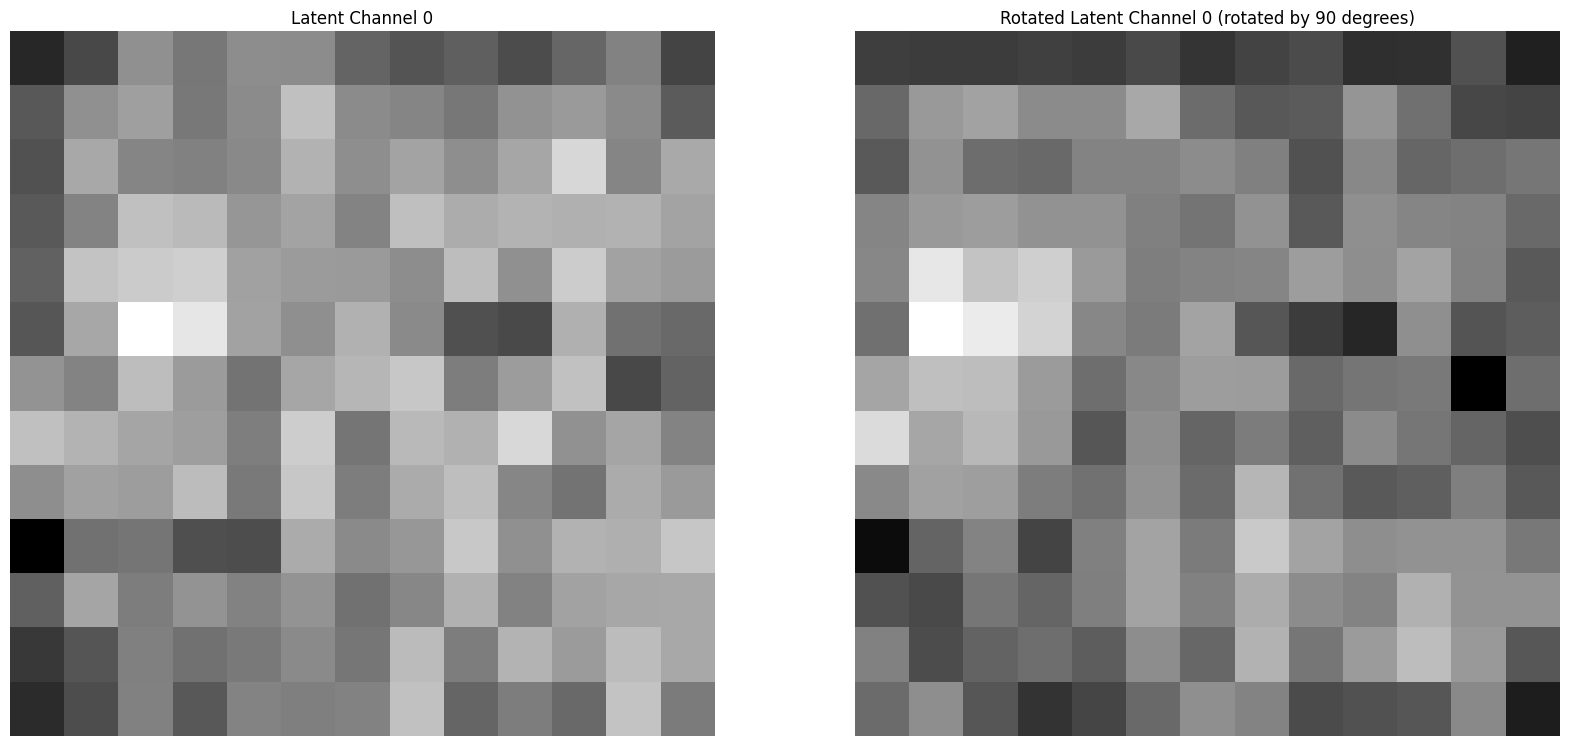

In [ ]:


plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0)

In [239]:
all_results_debug[0].keys()

dict_keys(['r0_nf', 'r0_f', 'r90_nf', 'r90_f', 'r180_nf', 'r180_f', 'r270_nf', 'r270_f'])

In [28]:
import matplotlib.pyplot as plt
plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0) # with impainting

NameError: name 'rotated_output' is not defined

Output is a dict
Latent shape: (1, 512, 13, 13), Rotated latent shape: torch.Size([1, 512, 13, 13])
Equivariance Error (MSE) for channel 0: 3.381205905539364e-13


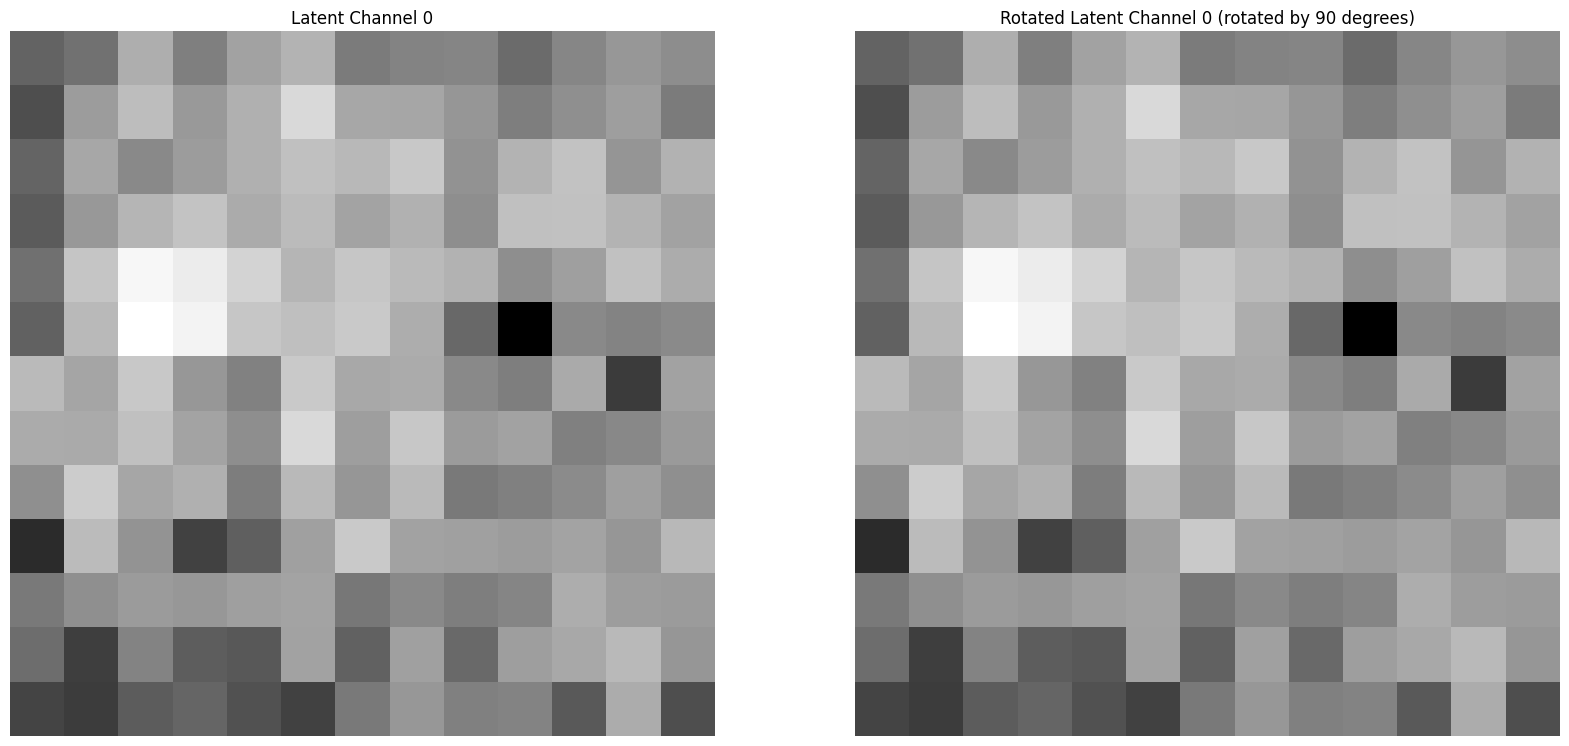

In [296]:

plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0) # no impainting

Latent shape: (1, 512, 15, 15), Rotated latent shape: torch.Size([1, 512, 15, 15])
Equivariance Error (MSE) for channel 0: 1.530046688458242e-06


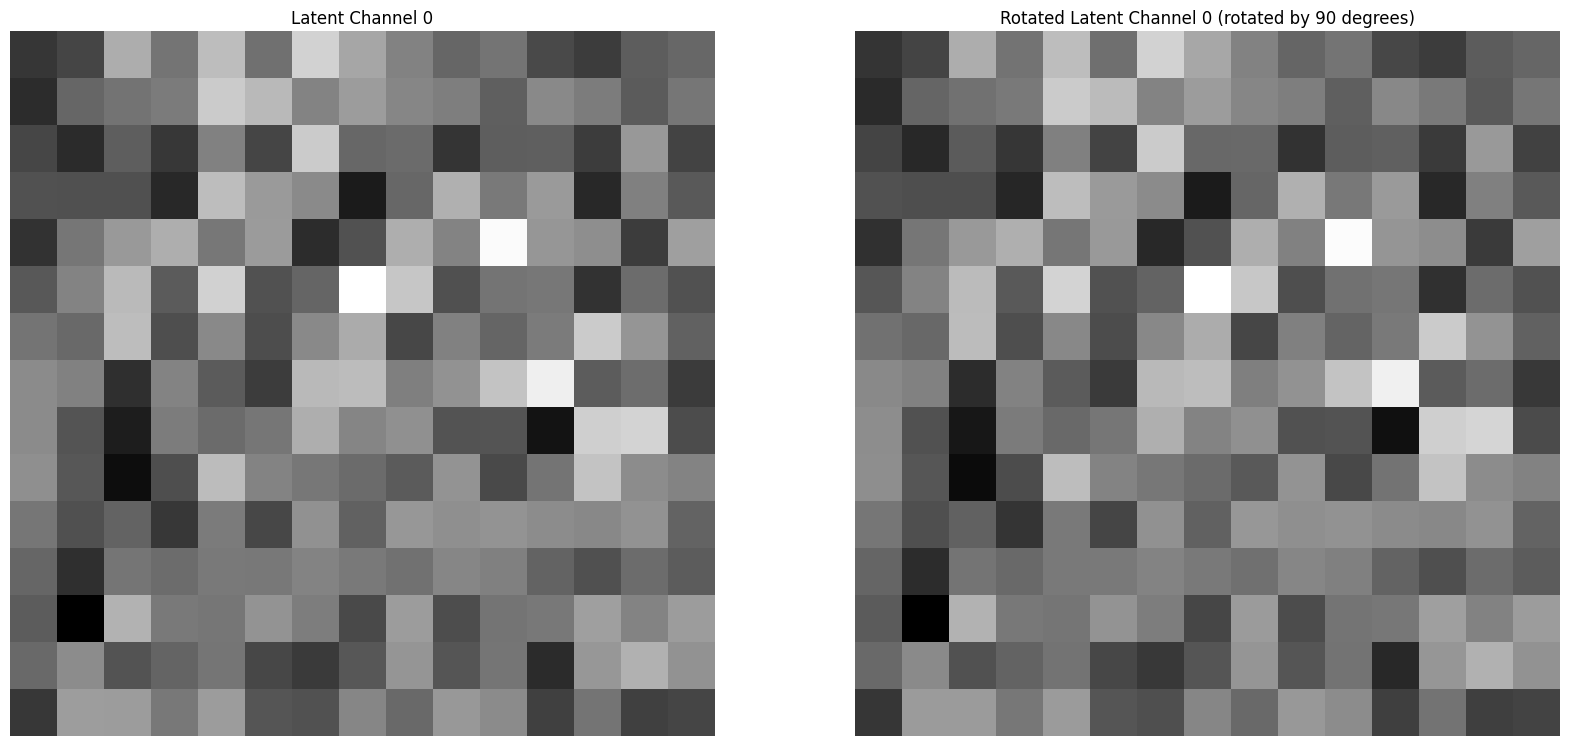

In [59]:
def plot_latents(output, rotated_output, rotation=90, layer_idx=-1, chanel_idx=0):
    if isinstance(output, dict):
        print("Output is a dict")
        latent = output["features"][layer_idx].detach().cpu().numpy()
        rotated_latent = rotated_output["features"][layer_idx].detach().cpu()
    else:
        latent = output
        rotated_latent = torch.tensor(rotated_output)
    print( f"Latent shape: {latent.shape}, Rotated latent shape: {rotated_latent.shape}")
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(latent[0, chanel_idx], cmap='gray')
    plt.title(f'Latent Channel {chanel_idx}')
    plt.axis('off')

    # rotated_latent_rotated_back = torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    rotated_latent_rotated_back = torch.rot90(rotated_latent, k=-rotation // 90, dims=(-2, -1)) if rotation % 90 == 0 else torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    rotated_latent_rotated_back = rotated_latent_rotated_back.numpy()
    plt.subplot(1, 2, 2)
    plt.imshow(rotated_latent_rotated_back[0, chanel_idx], cmap='gray')
    plt.title(f'Rotated Latent Channel {chanel_idx} (rotated by {rotation} degrees)')
    plt.axis('off')

    equivariance_error = np.square(latent - rotated_latent_rotated_back).mean().item()
    print(f'Equivariance Error (MSE) for channel {chanel_idx}: {equivariance_error}')

    plt.show()

idx = 2
plot_latents(all_results[idx]["r0_nf"][np.newaxis], all_results[idx]["r90_nf"][np.newaxis], rotation=90, chanel_idx=0)

Latent shape: torch.Size([1, 512, 13, 13]), Rotated latent shape: torch.Size([1, 512, 13, 13])
Equivariance Error (MSE) for channel 0: 0.008692783303558826


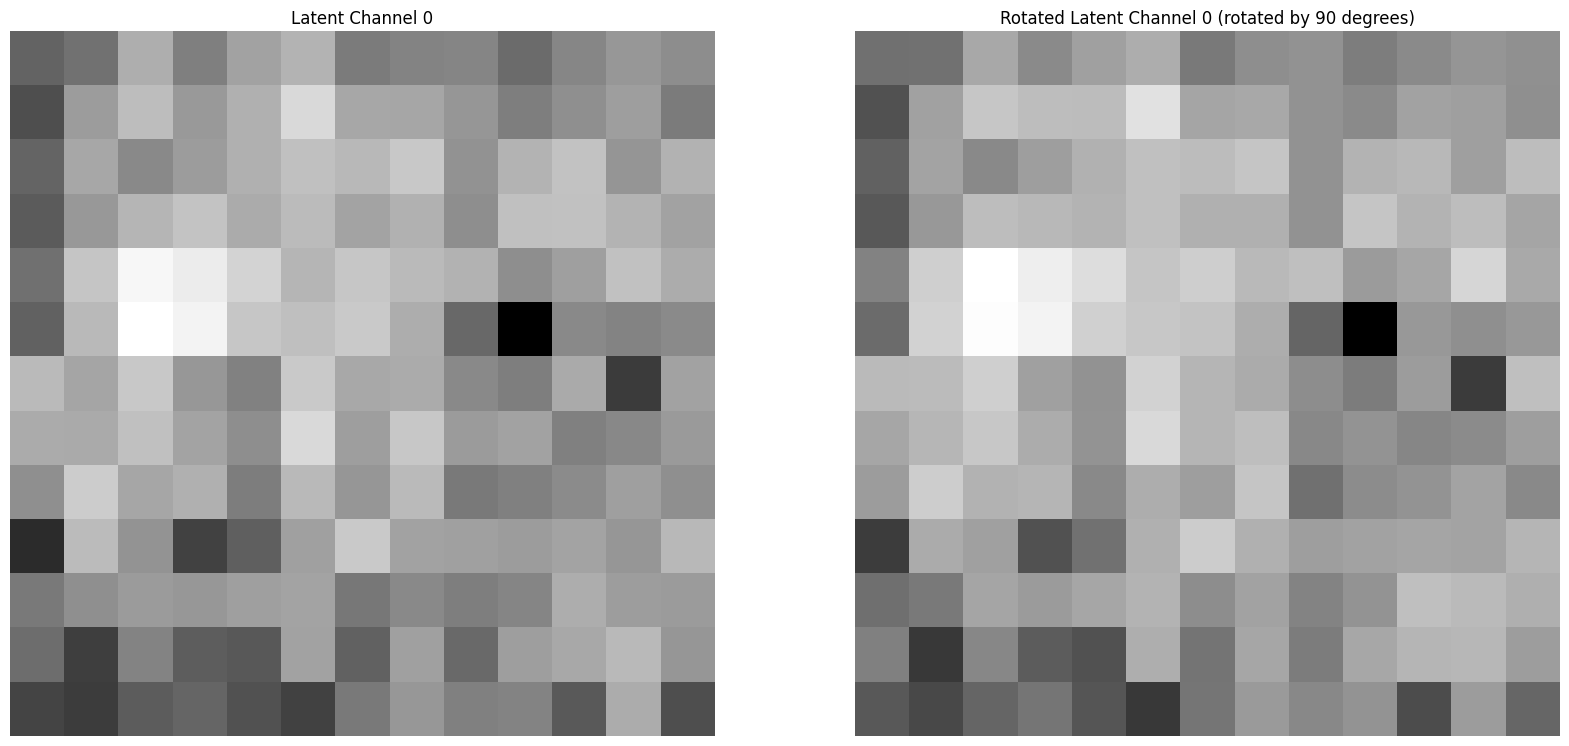

In [ ]:


plot_latents(all_results_debug[0]["r0_nf"][np.newaxis], all_results_debug[0]["r90_nf"][np.newaxis], rotation=90, chanel_idx=0)

In [280]:
all_results_debug[0]["r90_nf"].dtype

torch.float32

Latent shape: torch.Size([1, 512, 13, 13]), Rotated latent shape: torch.Size([1, 512, 13, 13])
Equivariance error (MSE) for channel 0: 3.338117813850988e-13


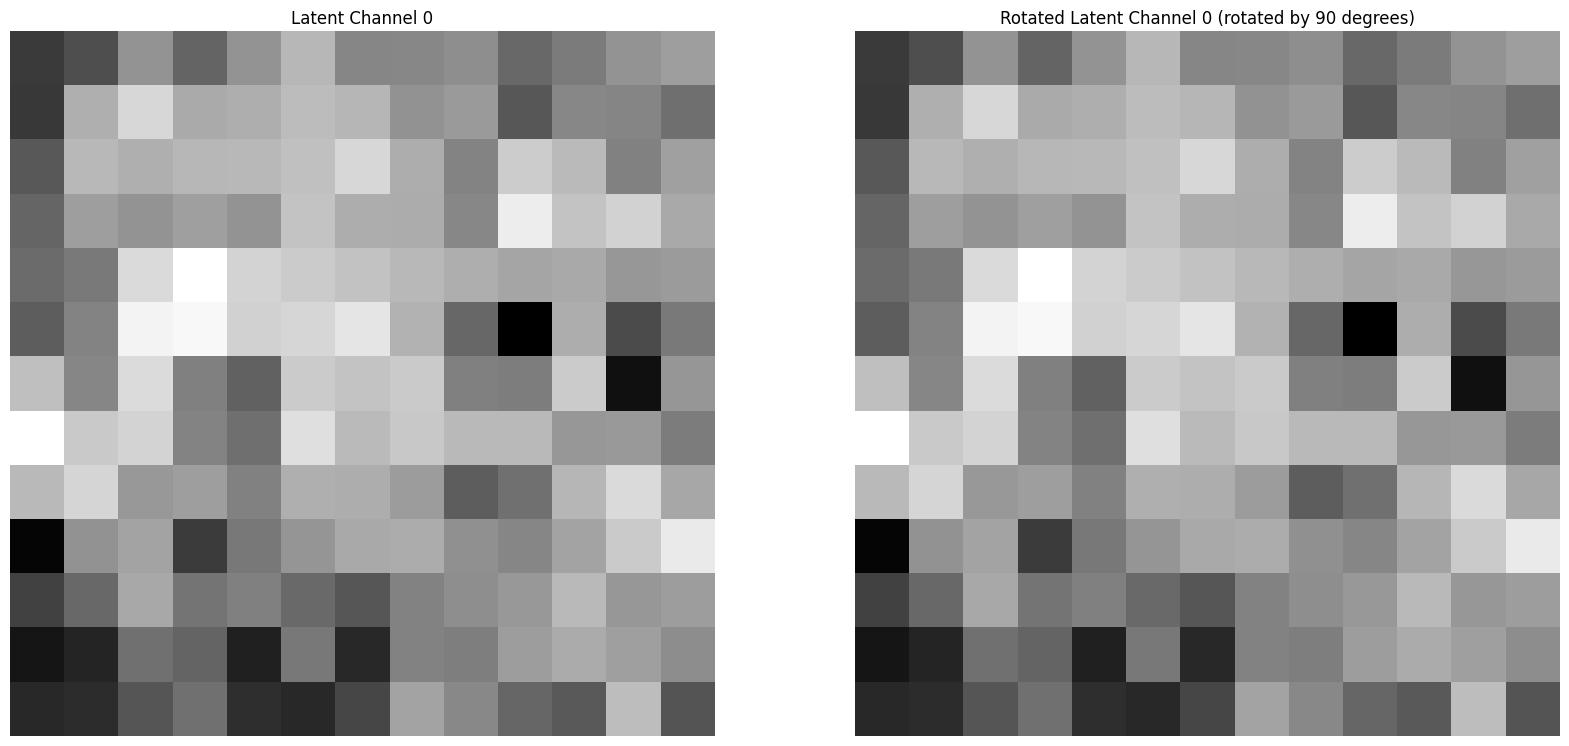

In [224]:
plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0)

In [175]:
output["output"].shape

torch.Size([1, 40, 104, 104, 2])

Latent shape: torch.Size([1, 40, 97, 97]), Rotated latent shape: torch.Size([1, 40, 97, 97])
Equivariance Error (MSE) for channel 0: 0.43997958302497864


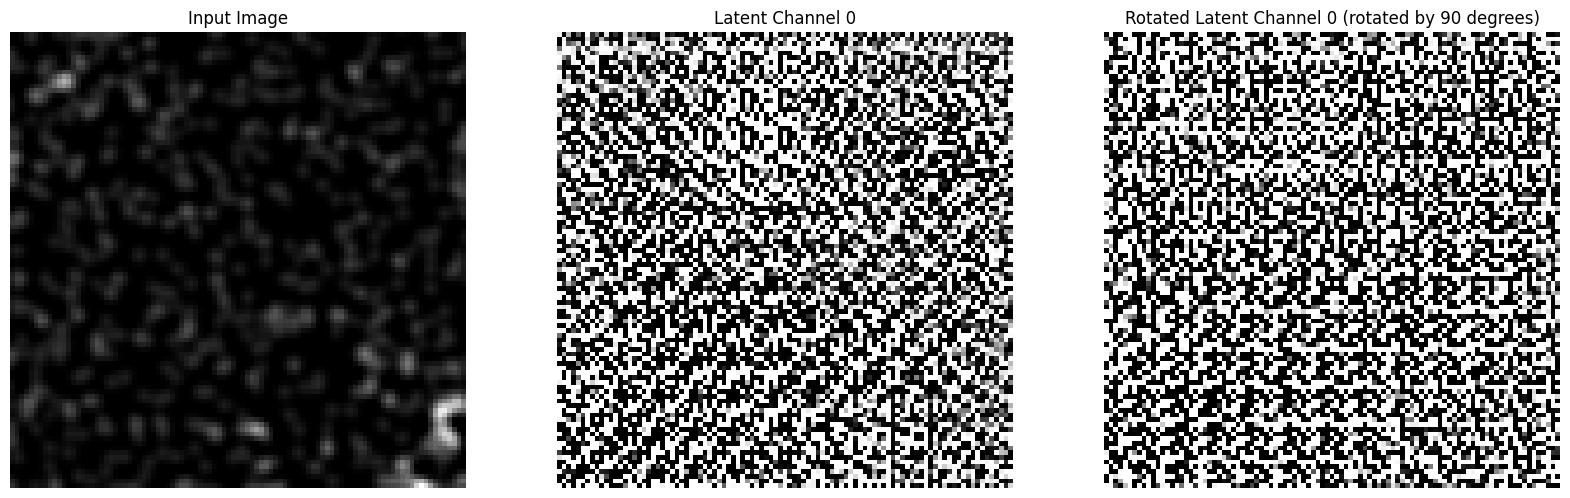

In [187]:
import matplotlib.pyplot as plt
def plot_reconstructions(img, output, rotated_output, rotation=90, layer_idx=-1, chanel_idx=0):
    latent = output["output"][:, :, 3:-4, 3:-4, 0].sigmoid()
    rotated_latent = rotated_output["output"][:, :, 3:-4, 3:-4, 0].sigmoid()
    print( f"Latent shape: {latent.shape}, Rotated latent shape: {rotated_latent.shape}")
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(img[0, chanel_idx].cpu().numpy(), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(latent[0, chanel_idx].cpu().numpy(), cmap='gray')
    plt.title(f'Latent Channel {chanel_idx}')
    plt.axis('off')

    # rotated_latent_rotated_back = torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    rotated_latent_rotated_back = torch.rot90(rotated_latent, k=-rotation // 90, dims=(-2, -1)) if rotation % 90 == 0 else torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    plt.subplot(1, 3, 3)
    plt.imshow(rotated_latent_rotated_back[0, chanel_idx].cpu().numpy(), cmap='gray')
    plt.title(f'Rotated Latent Channel {chanel_idx} (rotated by {rotation} degrees)')
    plt.axis('off')

    equivariance_error = torch.square(latent - rotated_latent_rotated_back).mean().item()
    print(f'Equivariance Error (MSE) for channel {chanel_idx}: {equivariance_error}')

    plt.show()

plot_reconstructions(img, output, rotated_output, rotation=ROTATION, chanel_idx=0)

Latent shape: torch.Size([1, 40, 97, 97]), Rotated latent shape: torch.Size([1, 40, 97, 97])
Equivariance Error (MSE) for channel 1: 4.5772383600706235e-05


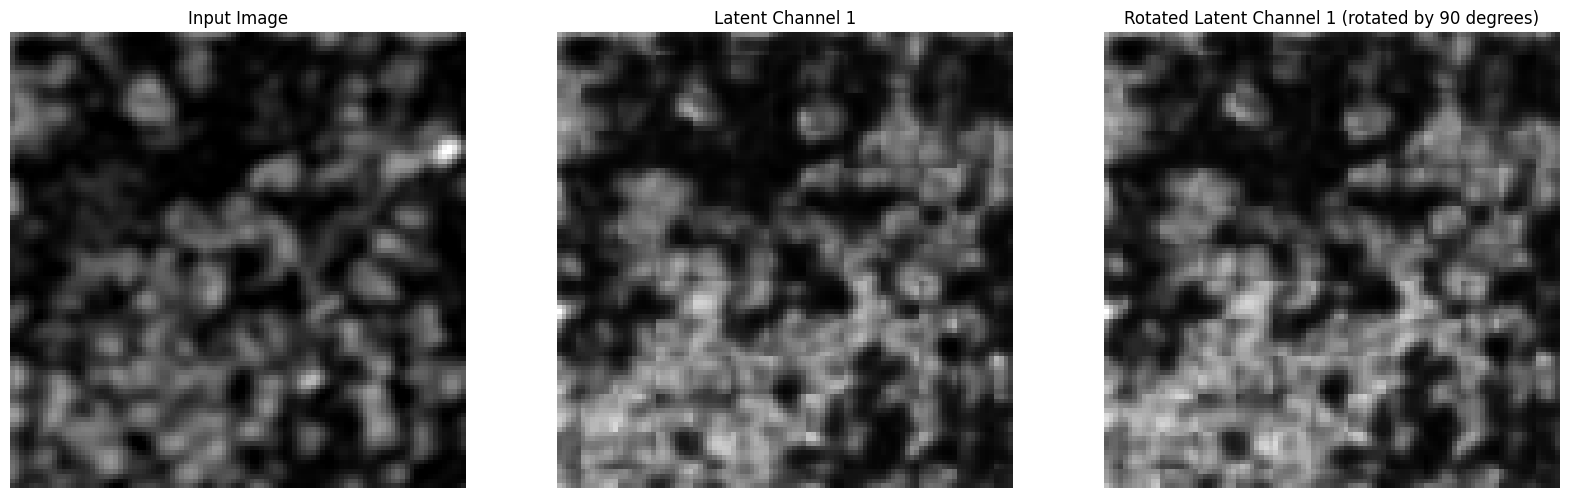

In [233]:
plot_reconstructions(img, output, rotated_output, rotation=ROTATION, chanel_idx=1)

Latent shape: torch.Size([1, 40, 97, 97]), Rotated latent shape: torch.Size([1, 40, 97, 97])
Equivariance Error (MSE) for channel 0: 0.4329908490180969


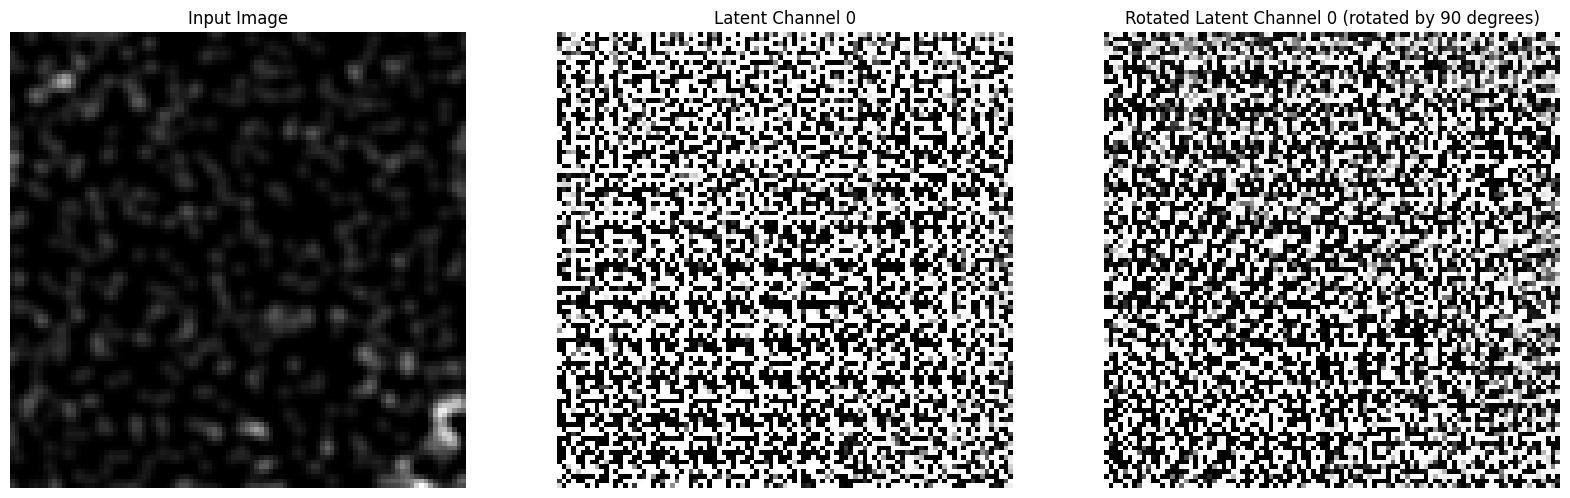

In [178]:

plot_reconstructions(img, output, rotated_output, rotation=ROTATION, chanel_idx=0)

Latent shape: torch.Size([1, 512, 13, 13]), Rotated latent shape: torch.Size([1, 512, 13, 13])
Equivariance error (MSE) for channel 0: 2.655425141925849e-12


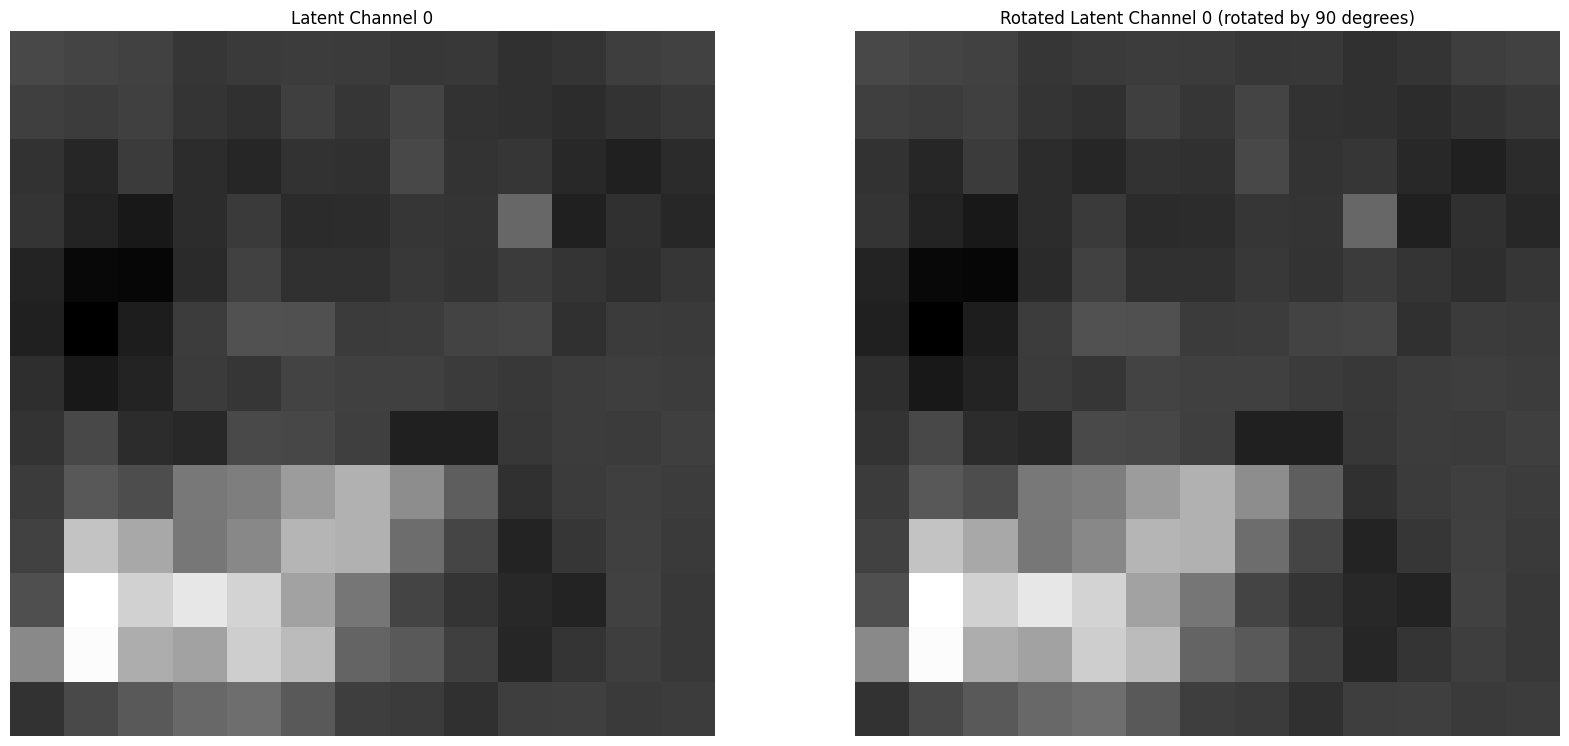

In [ ]:
# fresh model
plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0)

Latent shape: torch.Size([1, 512, 13, 13]), Rotated latent shape: torch.Size([1, 512, 13, 13])


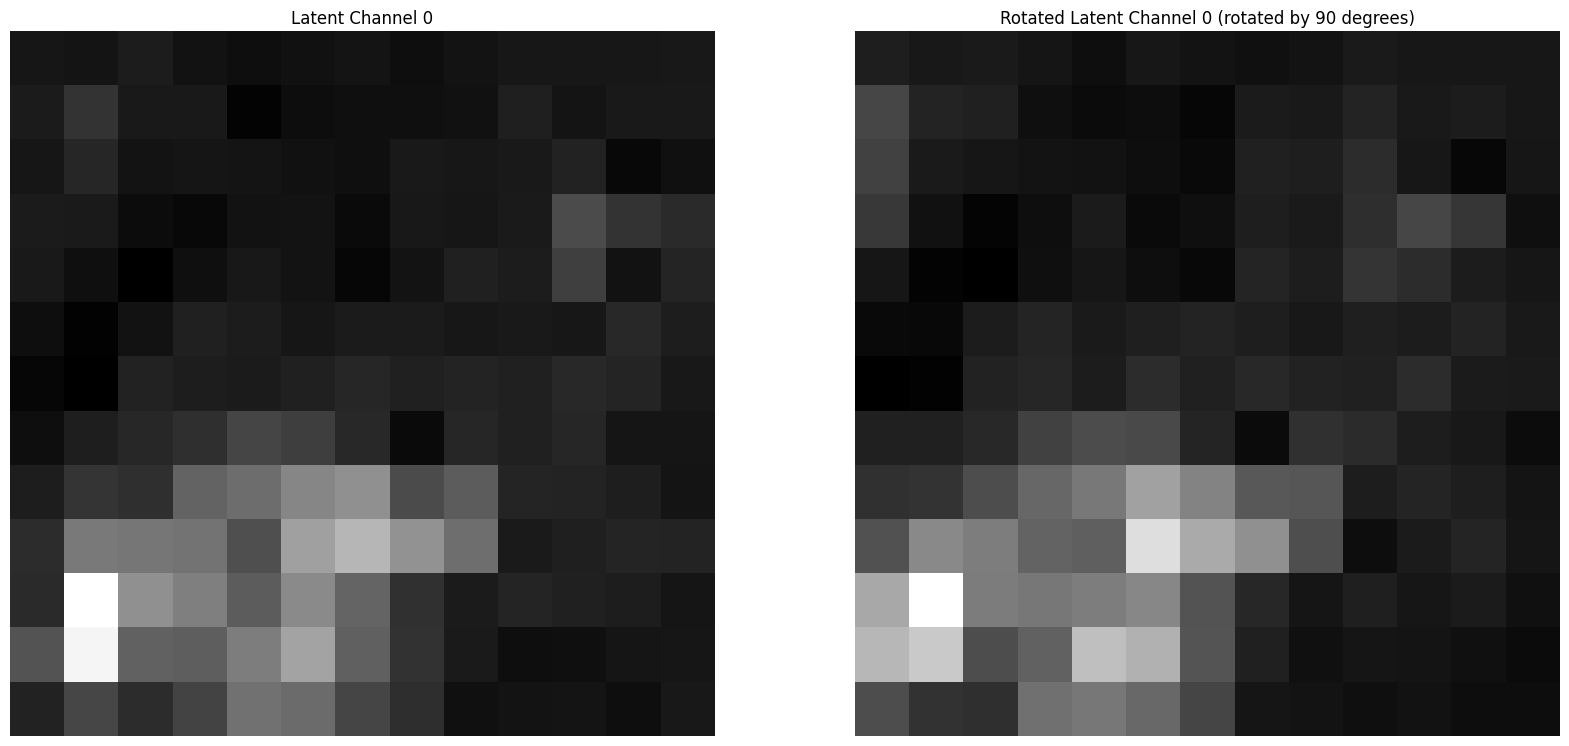

In [130]:
plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0)

In [133]:
import torchvision
# padding 1 + cropping
latent = output["features"][0]
rotated_latent = rotated_output["features"][0]
def calc_latent_rotation_error(latent, rotated_latent, rotation=90):
    """
    Calculate the error between the latent representation and its rotated version.
    """
    rotated_latent_rotated_back = torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    error = torch.abs(latent - rotated_latent_rotated_back)
    return error.mean().item() / latent.abs().mean().item()
error = calc_latent_rotation_error(latent, rotated_latent, rotation=ROTATION)
print(f"Latent rotation error: {error:.4f}")

Latent rotation error: 1.0895


In [ ]:
import matplotlib.pyplot as plt
def plot_latents(output, rotated_output, rotation=90, layer_idx=-1, chanel_idx=0):
    latent = output["features"][layer_idx]
    rotated_latent = rotated_output["features"][layer_idx]
    print( f"Latent shape: {latent.shape}, Rotated latent shape: {rotated_latent.shape}")
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(latent[0, chanel_idx].cpu().numpy(), cmap='gray')
    plt.title(f'Latent Channel {chanel_idx}')
    plt.axis('off')

    # rotated_latent_rotated_back = torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    rotated_latent_rotated_back = torch.rot90(rotated_latent, k=-rotation // 90, dims=(-2, -1)) if rotation % 90 == 0 else torchvision.transforms.functional.rotate(rotated_latent, -rotation)
    plt.subplot(1, 2, 2)
    plt.imshow(rotated_latent_rotated_back[0, chanel_idx].cpu().numpy(), cmap='gray')
    plt.title(f'Rotated Latent Channel {chanel_idx} (rotated by {rotation} degrees)')
    plt.axis('off')

    plt.show()

plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0)

In [ ]:
plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0)

In [ ]:
import math, torch, torchvision.transforms.functional as TF
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def rotate_tensor_affine(x, theta_deg, mode='bilinear'):
    theta = math.radians(theta_deg)
    B, C, H, W = x.shape
    # build homogeneous 3×3:  T_back · R · T_center
    cx, cy = (W-1)/2, (H-1)/2
    R = torch.tensor([[ math.cos(theta), -math.sin(theta), 0.],
                      [ math.sin(theta),  math.cos(theta), 0.],
                      [                0,               0, 1.]],
                     device=x.device, dtype=x.dtype)
    T = torch.tensor([[1, 0, -cx],
                      [0, 1, -cy],
                      [0, 0,   1]], device=x.device, dtype=x.dtype)
    T_back = torch.tensor([[1, 0, cx],
                           [0, 1, cy],
                           [0, 0,  1]], device=x.device, dtype=x.dtype)
    M = (T_back @ R @ T)[:2]                    # drop last row
    M = M.unsqueeze(0).repeat(B,1,1)            # (B,2,3)
    grid = F.affine_grid(M, x.size(), align_corners=False)
    return F.grid_sample(x, grid, mode=mode, padding_mode='zeros',
                         align_corners=False)

def circular_mask(H, W, device):
    """Largest inscribed circle for an H×W map."""
    Y, X = torch.meshgrid(torch.arange(H, device=device),
                          torch.arange(W, device=device),
                          indexing='ij')
    r2 = (X - W//2)**2 + (Y - H//2)**2
    return (r2 <= (min(H, W)//2)**2).float()          # (H,W)

def latent_equivariance_error(z0, zθ_back, theta_deg, use_mask=True):
    if use_mask:
        mask = circular_mask(*z0.shape[-2:], z0.device)
        z0, zθ_back = z0*mask, zθ_back*mask
    return (z0 - zθ_back).abs().mean() / z0.abs().mean()


# latent_rot_back = rotate_tensor_affine(rotated_features[-1], -ROTATION)
latent_rot_back = torch.rot90(rotated_features[-1], k=-ROTATION // 90, dims=(-2, -1)).to(dtype=torch.float32)


latent_equivariance_error(features[-1], latent_rot_back, ROTATION, use_mask=False)

In [ ]:
latent_equivariance_error(features[-1], rotate_tensor_affine(rotated_features[-1], -ROTATION), ROTATION, use_mask=False)

In [ ]:
plot_latents(output, rotated_output, rotation=ROTATION, chanel_idx=0)

In [ ]:
from multiplex_model.utils import plot_reconstructs_with_uncertainty
# def plot_reconstructs_with_uncertainty(
#         orig_img: torch.Tensor, 
#         reconstructed_img: torch.Tensor, 
#         sigma_plot: torch.Tensor,
#         channel_ids: torch.Tensor,
#         masked_ids: torch.Tensor, 
#         markers_names_map: Dict[int, str], 
#         ncols: int = 9,
#         scale_by_max: bool = True,
#     ):
uncertainty_img = torch.exp(logsigma)
unactive_channels = [i for i in channel_ids[0] if i not in active_channel_ids[0]]
masked_channels_names = '\n'.join([INV_TOKENIZER[i.item()] for i in unactive_channels])

plot_reconstructs_with_uncertainty(
    img,
    mi,
    uncertainty_img,
    channel_ids,
    unactive_channels,
    markers_names_map=INV_TOKENIZER,
    scale_by_max=True
)